# Funciones auxiliares

In [5]:
import numpy as np
import sklearn as sk
import pandas as pd
import copy
import matplotlib.pyplot as plt
import warnings
import heapq
import math

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import CategoricalNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsClassifier

warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Entrenamientos

In [6]:
#función que entrena una red ya definida previamente "evaluaciones" veces, cada vez entrenando un número de épocas elegido al crear la red y midiendo el error en train, validación y test al terminar ese paso de entrenamiento. 
#Guarda y devuelve la red en el paso de evaluación que da el mínimo error de validación
#entradas: la red, las veces que evalua, los datos de entrenamiento y sus respuestas, de validacion y sus respuestas, de test y sus respuestas
#salidas: la red entrenada en el mínimo de validación, los errores de train, validación y test medidos en cada evaluación
def entrenar_red(red, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test):
  if type(red) == MLPClassifier:
    errorFunc = sk.metrics.zero_one_loss
  else:
    errorFunc = sk.metrics.mean_squared_error

  best_err = 1

  errors_train, errors_val, errors_test = [], [], []
  for n in range(evaluaciones):
    red.fit(X_train, y_train)
    
    pred_train = red.predict(X_train)
    errors_train.append(errorFunc(y_train, pred_train))

    pred_val = red.predict(X_val)
    error_val = errorFunc(y_val, pred_val)
    errors_val.append(error_val)

    pred_test = red.predict(X_test)
    errors_test.append(errorFunc(y_test, pred_test))

    if error_val < best_err:
      best_err = error_val
      best_red = copy.deepcopy(red)

  return best_red, errors_train, errors_val, errors_test

In [7]:
def entrenar_red2(red, evaluaciones, X_train, y_train, X_test, y_test):
  if type(red) == MLPClassifier:
    errorFunc = sk.metrics.zero_one_loss
  else:
    errorFunc = sk.metrics.mean_squared_error

  errors_train, errors_test, weights = [], [], []
  for n in range(evaluaciones):
    red.fit(X_train, y_train)
    
    pred_train = red.predict(X_train)
    errors_train.append(errorFunc(y_train, pred_train))

    pred_test = red.predict(X_test)
    errors_test.append(errorFunc(y_test, pred_test))

    weights.append(np.sum([np.sum(np.square(w)) for w in red.coefs_]))

  return red, errors_train, errors_test, weights

In [8]:
def entrenar_knn(cls, maxK, xTrain, yTrain, xVal, yVal, xTest, yTest):
    if type(cls) == KNeighborsClassifier:
        errorFunc = sk.metrics.zero_one_loss
    else:
        errorFunc = sk.metrics.mean_squared_error

    errorsTrain = []
    errorsVal = []
    errorsTest = []
    bestError = 1

    for n in range(1, maxK):
        cls.n_neighbors = n
        cls.fit(xTrain, yTrain)
        
        errorsTrain.append(errorFunc(yTrain, cls.predict(xTrain)))
        errorVal = errorFunc(yVal, cls.predict(xVal))
        errorsVal.append(errorVal)
        errorsTest.append(errorFunc(yTest, cls.predict(xTest)))

        if (errorVal < bestError):
            bestError = errorVal
            bestKNN = copy.deepcopy(cls)

    return bestKNN, errorsTrain, errorsVal, errorsTest

## Aux

In [9]:
def minError(list):
    bestError = 1
    for (train, val, test) in list:
        if val < bestError:
            bestError = val
            bestTrainError = train
            bestTestError = test
    return bestTrainError, bestTestError

## Generadores

In [10]:
def centroGauss(d, v):
  return [v]*d

def covMatrix(d, C):
  return np.identity(d)*([(C*np.sqrt(d))**2]*d)

def diagonales(n, d, C):
  n0 = int(n/2)
  n1 = n - n0
  matriz = covMatrix(d, C)
  valores0 = np.random.multivariate_normal(centroGauss(d, -1), matriz, n0)
  valores1 = np.random.multivariate_normal(centroGauss(d, 1), matriz, n1)

  data = [[0, *x] for x in valores0] + [[1, *x] for x in valores1]

  return pd.DataFrame(data, columns=['Target', *['d' + str(x + 1) for x in range(d)]])

In [11]:
def covMatrixP(d, C):
  return np.identity(d)*([C**2]*d)

def paralelas(n, d, C):
  n0 = int(n/2)
  n1 = n - n0
  matriz = covMatrixP(d, C)
  centro = centroGauss(d, 0)
  centro[0] = -1
  valores0 = np.random.multivariate_normal(centro, matriz, n0)
  centro[0] = 1
  valores1 = np.random.multivariate_normal(centro, matriz, n1)

  data = [[0, *x] for x in valores0] + [[1, *x] for x in valores1]

  return pd.DataFrame(data, columns=['Target', *['d' + str(x + 1) for x in range(d)]])

In [12]:
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def is_inside_curve(rho, theta, npi):
  rho_curve1 = (theta + (npi-1)*np.pi) / (4 * np.pi)
  rho_curve2 = (theta + npi*np.pi) / (4 * np.pi)
  return rho_curve1 <= rho <= rho_curve2

def is_inside_curves(x, y):
    rho, theta = cartesian_to_polar(x, y)
    return is_inside_curve(rho, theta, 1) or is_inside_curve(rho, theta, 3) or is_inside_curve(rho, theta, 5)

def espirales(n):
  n0 = int(n/2)
  n1 = n - n0
  i0, i1 = 0, 0
  values0, values1 = [], []
  while (i0 + i1 < n):
    x, y = np.random.uniform(-1, 1, 2)
    if (np.sqrt(x**2 + y**2) > 1):
      continue
    if (is_inside_curves(x, y)):
      if (i0 != n0):
        values0.append([x, y])
        i0 += 1
    else:
      if (i1 != n1):
        values1.append([x, y])
        i1 += 1

  data = [[0, *x] for x in values0] + [[1, *x] for x in values1]

  return pd.DataFrame(data, columns=['Target', 'd1', 'd2'])

## Plots

In [13]:
def plotGrafico(title, x, y):
  i, n = 0, len(y)
  xs0, ys0, xs1, ys1 = [], [], [], []
  while (i < n):
    if (y[i] == 0):
      xs0.append(x[i][0])
      ys0.append(x[i][1])
    else:
      xs1.append(x[i][0])
      ys1.append(x[i][1])
    i += 1

  plt.scatter(xs0, ys0, color='red', facecolors='none', label='Clase 0')
  plt.scatter(xs1, ys1, color='green', facecolors='none', label='Clase 1')
  plt.legend()
  plt.title(title)
  plt.show()

In [14]:
def plotEntrenamiento2(title, error_train, error_val, error_test, rango):
  plt.figure(figsize=(20,12))
  plt.plot(rango, error_train, label="Train", linestyle=":")
  plt.plot(rango, error_val, label="Val", linestyle="-.")
  plt.plot(rango, error_test, label="Test", linestyle="-")
  
  plt.legend()
  plt.title(title)
  plt.show()

In [15]:
def plotEntrenamiento3(title, arbol, ann, nb, ko, k1, dimentions):
    plt.figure(figsize=(20, 12))
    
    # Assign colors to each IA
    colors = {
        'Tree': 'blue',
        'ANN': 'green',
        'NB': 'purple',
        'K opt': 'pink',
        'K1': 'olive'
    }

    # Plot each IA with different colors and line styles
    plt.plot(dimentions, arbol[0], label='Tree Train', linestyle="-.", color=colors['Tree'])
    plt.plot(dimentions, arbol[1], label='Tree Test', linestyle="-", color=colors['Tree'])
    plt.plot(dimentions, ann[0], label='ANN Train', linestyle="-.", color=colors['ANN'])
    plt.plot(dimentions, ann[1], label='ANN Test', linestyle="-", color=colors['ANN'])
    plt.plot(dimentions, nb[0], label='NB Train', linestyle="-.", color=colors['NB'])
    plt.plot(dimentions, nb[1], label='NB Test', linestyle="-", color=colors['NB'])
    plt.plot(dimentions, ko[0], label='K opt Train', linestyle="-.", color=colors['K opt'])
    plt.plot(dimentions, ko[1], label='K opt Test', linestyle="-", color=colors['K opt'])
    plt.plot(dimentions, k1[0], label='K1 Train', linestyle="-.", color=colors['K1'])
    plt.plot(dimentions, k1[1], label='K1 Test', linestyle="-", color=colors['K1'])

    # Scatter each point with corresponding colors
    plt.scatter(dimentions, arbol[0], color=colors['Tree'], s=50)
    plt.scatter(dimentions, arbol[1], color=colors['Tree'], s=50)
    plt.scatter(dimentions, ann[0], color=colors['ANN'], s=50)
    plt.scatter(dimentions, ann[1], color=colors['ANN'], s=50)
    plt.scatter(dimentions, nb[0], color=colors['NB'], s=50)
    plt.scatter(dimentions, nb[1], color=colors['NB'], s=50)
    plt.scatter(dimentions, ko[0], color=colors['K opt'], s=50)
    plt.scatter(dimentions, ko[1], color=colors['K opt'], s=50)
    plt.scatter(dimentions, k1[0], color=colors['K1'], s=50)
    plt.scatter(dimentions, k1[1], color=colors['K1'], s=50)

    # Set the x-ticks and labels
    plt.xticks(dimentions, labels=[str(i) for i in dimentions])
    plt.legend()
    plt.title(title)
    plt.show()

In [16]:
def plotEntrenamiento4(title, arbol_diag, arbol_para, ann_diag, ann_para, nb_diag, nb_para, ko_diag, ko_para, k1_diag, k1_para, dimentions):
    plt.figure(figsize=(20, 12))
    
    # Assign colors to each IA
    colors = {
        'Tree': 'blue',
        'ANN': 'green',
        'NB': 'purple',
        'K opt': 'orange',
        'K1': 'red'
    }

    # Plot each IA with different colors and line styles
    plt.plot(dimentions, arbol_diag[0], label='Diagonal Tree Train', linestyle="-.", color=colors['Tree'], marker='x')
    plt.plot(dimentions, arbol_diag[1], label='Diagonal Tree Test', linestyle="-", color=colors['Tree'], marker='x')
    plt.plot(dimentions, arbol_para[0], label='Paralel Tree Train', linestyle="-.", color=colors['Tree'], marker='o')
    plt.plot(dimentions, arbol_para[1], label='Paralel Tree Test', linestyle="-", color=colors['Tree'], marker='o')
    plt.plot(dimentions, ann_diag[0], label='Diagonal ANN Train', linestyle="-.", color=colors['ANN'], marker='x')
    plt.plot(dimentions, ann_diag[1], label='Diagonal ANN Test', linestyle="-", color=colors['ANN'], marker='x')
    plt.plot(dimentions, ann_para[0], label='Paralel ANN Train', linestyle="-.", color=colors['ANN'], marker='o')
    plt.plot(dimentions, ann_para[1], label='Paralel ANN Test', linestyle="-", color=colors['ANN'], marker='o')
    plt.plot(dimentions, nb_diag[0], label='Diagonal NB Train', linestyle="-.", color=colors['NB'], marker='x')
    plt.plot(dimentions, nb_diag[1], label='Diagonal NB Test', linestyle="-", color=colors['NB'], marker='x')
    plt.plot(dimentions, nb_para[0], label='Paralel NB Train', linestyle="-.", color=colors['NB'], marker='o')
    plt.plot(dimentions, nb_para[1], label='Paralel NB Test', linestyle="-", color=colors['NB'], marker='o')
    plt.plot(dimentions, ko_diag[0], label='Diagonal K opt Train', linestyle="-.", color=colors['K opt'], marker='x')
    plt.plot(dimentions, ko_diag[1], label='Diagonal K opt Test', linestyle="-", color=colors['K opt'], marker='x')
    plt.plot(dimentions, ko_para[0], label='Paralel K opt Train', linestyle="-.", color=colors['K opt'], marker='o')
    plt.plot(dimentions, ko_para[1], label='Paralel K opt Test', linestyle="-", color=colors['K opt'], marker='o')
    plt.plot(dimentions, k1_diag[0], label='Diagonal K1 Train', linestyle="-.", color=colors['K1'], marker='x')
    plt.plot(dimentions, k1_diag[1], label='Diagonal K1 Test', linestyle="-", color=colors['K1'], marker='x')
    plt.plot(dimentions, k1_para[0], label='Paralel K1 Train', linestyle="-.", color=colors['K1'], marker='o')
    plt.plot(dimentions, k1_para[1], label='Paralel K1 Test', linestyle="-", color=colors['K1'], marker='o')

    # Scatter each point with corresponding colors and markers
    plt.scatter(dimentions, arbol_diag[0], color=colors['Tree'], s=100, marker='x')
    plt.scatter(dimentions, arbol_diag[1], color=colors['Tree'], s=100, marker='x')
    plt.scatter(dimentions, arbol_para[0], color=colors['Tree'], s=100, marker='o')
    plt.scatter(dimentions, arbol_para[1], color=colors['Tree'], s=100, marker='o')
    plt.scatter(dimentions, ann_diag[0], color=colors['ANN'], s=100, marker='x')
    plt.scatter(dimentions, ann_diag[1], color=colors['ANN'], s=100, marker='x')
    plt.scatter(dimentions, ann_para[0], color=colors['ANN'], s=100, marker='o')
    plt.scatter(dimentions, ann_para[1], color=colors['ANN'], s=100, marker='o')
    plt.scatter(dimentions, nb_diag[0], color=colors['NB'], s=100, marker='x')
    plt.scatter(dimentions, nb_diag[1], color=colors['NB'], s=100, marker='x')
    plt.scatter(dimentions, nb_para[0], color=colors['NB'], s=100, marker='o')
    plt.scatter(dimentions, nb_para[1], color=colors['NB'], s=100, marker='o')
    plt.scatter(dimentions, ko_diag[0], color=colors['K opt'], s=100, marker='x')
    plt.scatter(dimentions, ko_diag[1], color=colors['K opt'], s=100, marker='x')
    plt.scatter(dimentions, ko_para[0], color=colors['K opt'], s=100, marker='o')
    plt.scatter(dimentions, ko_para[1], color=colors['K opt'], s=100, marker='o')
    plt.scatter(dimentions, k1_diag[0], color=colors['K1'], s=100, marker='x')
    plt.scatter(dimentions, k1_diag[1], color=colors['K1'], s=100, marker='x')
    plt.scatter(dimentions, k1_para[0], color=colors['K1'], s=100, marker='o')
    plt.scatter(dimentions, k1_para[1], color=colors['K1'], s=100, marker='o')

    # Set the x-ticks and labels
    plt.xticks(dimentions, labels=[str(i) for i in dimentions])
    plt.legend()
    plt.title(title)
    plt.show()

In [17]:
def plotEntrenamiento5(title, diag_ko, para_ko, diag_k1, para_k1, diag_kow, para_kow, diag_k50w, para_k50w, dimentions):
  plt.figure(figsize=(20,12))
  
  colors = {
      'KOW': 'green',
      'K50W': 'purple',
      'KO': 'orange',
      'K1': 'red'
  }
  
  plt.plot(dimentions, diag_ko[0], linestyle="-.", label='Diagonal Uniform K opt Train', color=colors['KO'], marker='x')
  plt.plot(dimentions, diag_ko[1], linestyle="-", label='Diagonal Uniform K opt Test', color=colors['KO'], marker='x')
  plt.plot(dimentions, para_ko[0], linestyle="-.", label='Paralela Uniform K opt Train', color=colors['KO'], marker='o')
  plt.plot(dimentions, para_ko[1], linestyle="-", label='Paralela Uniform K opt Test', color=colors['KO'], marker='o')
  plt.plot(dimentions, diag_k1[0], linestyle="-.", label='Diagonal Uniform K1 Train', color=colors['K1'], marker='x')
  plt.plot(dimentions, diag_k1[1], linestyle="-", label='Diagonal Uniform K1 Test', color=colors['K1'], marker='x')
  plt.plot(dimentions, para_k1[0], linestyle="-.", label='Paralela Uniform K1 Train', color=colors['K1'], marker='o')
  plt.plot(dimentions, para_k1[1], linestyle="-", label='Paralela Uniform K1 Test', color=colors['K1'], marker='o')
  plt.plot(dimentions, diag_kow[0], linestyle="-.", label='Diagonal Weighted K opt Train', color=colors['KOW'], marker='x')
  plt.plot(dimentions, diag_kow[1], linestyle="-", label='Diagonal Weighted K opt Test', color=colors['KOW'], marker='x')
  plt.plot(dimentions, para_kow[0], linestyle="-.", label='Paralela Weighted K opt Train', color=colors['KOW'], marker='o')
  plt.plot(dimentions, para_kow[1], linestyle="-", label='Paralela Weighted K opt Test', color=colors['KOW'], marker='o')
  plt.plot(dimentions, diag_k50w[0], linestyle="-.", label='Diagonal Weighted K50 Train', color=colors['K50W'], marker='x')
  plt.plot(dimentions, diag_k50w[1], linestyle="-", label='Diagonal Weighted K50 Test', color=colors['K50W'], marker='x')
  plt.plot(dimentions, para_k50w[0], linestyle="-.", label='Paralela Weighted K50 Train', color=colors['K50W'], marker='o')
  plt.plot(dimentions, para_k50w[1], linestyle="-", label='Paralela Weighted K50 Test', color=colors['K50W'], marker='o')

  plt.scatter(dimentions, diag_ko[0], color=colors['KO'], s=50, marker='x')
  plt.scatter(dimentions, diag_ko[1], color=colors['KO'], s=50, marker='x')
  plt.scatter(dimentions, para_ko[0], color=colors['KO'], s=50, marker='o')
  plt.scatter(dimentions, para_ko[1], color=colors['KO'], s=50, marker='o')
  plt.scatter(dimentions, diag_k1[0], color=colors['K1'], s=50, marker='x')
  plt.scatter(dimentions, diag_k1[1], color=colors['K1'], s=50, marker='x')
  plt.scatter(dimentions, para_k1[0], color=colors['K1'], s=50, marker='o')
  plt.scatter(dimentions, para_k1[1], color=colors['K1'], s=50, marker='o')
  plt.scatter(dimentions, diag_kow[0], color=colors['KOW'], s=50, marker='x')
  plt.scatter(dimentions, diag_kow[1], color=colors['KOW'], s=50, marker='x')
  plt.scatter(dimentions, para_kow[0], color=colors['KOW'], s=50, marker='o')
  plt.scatter(dimentions, para_kow[1], color=colors['KOW'], s=50, marker='o')
  plt.scatter(dimentions, diag_k50w[0], color=colors['K50W'], s=50, marker='x')
  plt.scatter(dimentions, diag_k50w[1], color=colors['K50W'], s=50, marker='x')
  plt.scatter(dimentions, para_k50w[0], color=colors['K50W'], s=50, marker='o')
  plt.scatter(dimentions, para_k50w[1], color=colors['K50W'], s=50, marker='o')

  plt.xticks(dimentions, labels=[str(i) for i in dimentions])
  plt.legend()
  plt.title(title)
  plt.show()

In [18]:
def plotEntrenamiento6(title, diag_ko, para_ko, diag_kf, para_kf, dimentions):
    plt.figure(figsize=(20, 12))

    # Asignar colores a cada IA
    colors = {
        'K opt': 'orange',
        'K1': 'red'
    }

    # Graficar cada IA con diferentes colores y estilos de línea
    plt.plot(dimentions, diag_ko[0], linestyle="-.", label='Diagonal K opt Train', color=colors['K opt'], marker='x')
    plt.plot(dimentions, diag_ko[1], linestyle="-", label='Diagonal K opt Test', color=colors['K opt'], marker='x')
    plt.plot(dimentions, para_ko[0], linestyle="-.", label='Paralela K opt Train', color=colors['K opt'], marker='o')
    plt.plot(dimentions, para_ko[1], linestyle="-", label='Paralela K opt Test', color=colors['K opt'], marker='o')
    plt.plot(dimentions, diag_kf[0], linestyle="-.", label='Diagonal K1 Train', color=colors['K1'], marker='x')
    plt.plot(dimentions, diag_kf[1], linestyle="-", label='Diagonal K1 Test', color=colors['K1'], marker='x')
    plt.plot(dimentions, para_kf[0], linestyle="-.", label='Paralela K1 Train', color=colors['K1'], marker='o')
    plt.plot(dimentions, para_kf[1], linestyle="-", label='Paralela K1 Test', color=colors['K1'], marker='o')

    # Graficar los puntos con marcadores diferentes para diagonal y paralela
    plt.scatter(dimentions, diag_ko[0], color=colors['K opt'], s=100, marker='x')
    plt.scatter(dimentions, diag_ko[1], color=colors['K opt'], s=100, marker='x')
    plt.scatter(dimentions, para_ko[0], color=colors['K opt'], s=100, marker='o')
    plt.scatter(dimentions, para_ko[1], color=colors['K opt'], s=100, marker='o')
    plt.scatter(dimentions, diag_kf[0], color=colors['K1'], s=100, marker='x')
    plt.scatter(dimentions, diag_kf[1], color=colors['K1'], s=100, marker='x')
    plt.scatter(dimentions, para_kf[0], color=colors['K1'], s=100, marker='o')
    plt.scatter(dimentions, para_kf[1], color=colors['K1'], s=100, marker='o')

    # Establecer los x-ticks y las etiquetas
    plt.xticks(dimentions, labels=[str(i) for i in dimentions])
    plt.legend()
    plt.title(title)
    plt.show()

In [19]:
def plotEntrenamiento7(title, diag_ko, para_ko, diag_kf, para_kf, dimentions):
    plt.figure(figsize=(20, 12))
    
    # Asignar colores a cada IA
    colors = {
        'K opt': 'green',
        'K50': 'purple'
    }

    # Graficar cada IA con diferentes colores y estilos de línea
    plt.plot(dimentions, diag_ko[0], linestyle="-.", label='Diagonal K opt Train', color=colors['K opt'], marker='x')
    plt.plot(dimentions, diag_ko[1], linestyle="-", label='Diagonal K opt Test', color=colors['K opt'], marker='x')
    plt.plot(dimentions, para_ko[0], linestyle="-.", label='Paralela K opt Train', color=colors['K opt'], marker='o')
    plt.plot(dimentions, para_ko[1], linestyle="-", label='Paralela K opt Test', color=colors['K opt'], marker='o')
    plt.plot(dimentions, diag_kf[0], linestyle="-.", label='Diagonal K50 Train', color=colors['K50'], marker='x')
    plt.plot(dimentions, diag_kf[1], linestyle="-", label='Diagonal K50 Test', color=colors['K50'], marker='x')
    plt.plot(dimentions, para_kf[0], linestyle="-.", label='Paralela K50 Train', color=colors['K50'], marker='o')
    plt.plot(dimentions, para_kf[1], linestyle="-", label='Paralela K50 Test', color=colors['K50'], marker='o')

    # Graficar los puntos con marcadores diferentes para diagonal y paralela
    plt.scatter(dimentions, diag_ko[0], color=colors['K opt'], s=100, marker='x')
    plt.scatter(dimentions, diag_ko[1], color=colors['K opt'], s=100, marker='x')
    plt.scatter(dimentions, para_ko[0], color=colors['K opt'], s=100, marker='o')
    plt.scatter(dimentions, para_ko[1], color=colors['K opt'], s=100, marker='o')
    plt.scatter(dimentions, diag_kf[0], color=colors['K50'], s=100, marker='x')
    plt.scatter(dimentions, diag_kf[1], color=colors['K50'], s=100, marker='x')
    plt.scatter(dimentions, para_kf[0], color=colors['K50'], s=100, marker='o')
    plt.scatter(dimentions, para_kf[1], color=colors['K50'], s=100, marker='o')

    # Establecer los x-ticks y las etiquetas
    plt.xticks(dimentions, labels=[str(i) for i in dimentions])
    plt.legend()
    plt.title(title)
    plt.show()

In [20]:
def plotEntrenamiento8(title, diag_d, para_d, diag_kow, para_kow, diag_k50w, para_k50w, dimentions):
    plt.figure(figsize=(20, 12))
    
    # Asignar colores a cada tipo de IA
    colors = {
        'Radius': 'blue',
        'K opt': 'green',
        'K50': 'red'
    }

    # Graficar cada tipo de IA con diferentes colores y estilos de línea
    plt.plot(dimentions, diag_d[0], linestyle="-.", label='Diagonal Radius Train', color=colors['Radius'], marker='x')
    plt.plot(dimentions, diag_d[1], linestyle="-", label='Diagonal Radius Test', color=colors['Radius'], marker='x')
    plt.plot(dimentions, para_d[0], linestyle="-.", label='Paralela Radius Train', color=colors['Radius'], marker='o')
    plt.plot(dimentions, para_d[1], linestyle="-", label='Paralela Radius Test', color=colors['Radius'], marker='o')
    
    plt.plot(dimentions, diag_kow[0], linestyle="-.", label='Diagonal K opt Train', color=colors['K opt'], marker='x')
    plt.plot(dimentions, diag_kow[1], linestyle="-", label='Diagonal K opt Test', color=colors['K opt'], marker='x')
    plt.plot(dimentions, para_kow[0], linestyle="-.", label='Paralela K opt Train', color=colors['K opt'], marker='o')
    plt.plot(dimentions, para_kow[1], linestyle="-", label='Paralela K opt Test', color=colors['K opt'], marker='o')
    
    plt.plot(dimentions, diag_k50w[0], linestyle="-.", label='Diagonal K50 Train', color=colors['K50'], marker='x')
    plt.plot(dimentions, diag_k50w[1], linestyle="-", label='Diagonal K50 Test', color=colors['K50'], marker='x')
    plt.plot(dimentions, para_k50w[0], linestyle="-.", label='Paralela K50 Train', color=colors['K50'], marker='o')
    plt.plot(dimentions, para_k50w[1], linestyle="-", label='Paralela K50 Test', color=colors['K50'], marker='o')

    # Graficar los puntos con marcadores diferentes para diagonal y paralela
    plt.scatter(dimentions, diag_d[0], color=colors['Radius'], s=100, marker='x')
    plt.scatter(dimentions, diag_d[1], color=colors['Radius'], s=100, marker='x')
    plt.scatter(dimentions, para_d[0], color=colors['Radius'], s=100, marker='o')
    plt.scatter(dimentions, para_d[1], color=colors['Radius'], s=100, marker='o')
    
    plt.scatter(dimentions, diag_kow[0], color=colors['K opt'], s=100, marker='x')
    plt.scatter(dimentions, diag_kow[1], color=colors['K opt'], s=100, marker='x')
    plt.scatter(dimentions, para_kow[0], color=colors['K opt'], s=100, marker='o')
    plt.scatter(dimentions, para_kow[1], color=colors['K opt'], s=100, marker='o')
    
    plt.scatter(dimentions, diag_k50w[0], color=colors['K50'], s=100, marker='x')
    plt.scatter(dimentions, diag_k50w[1], color=colors['K50'], s=100, marker='x')
    plt.scatter(dimentions, para_k50w[0], color=colors['K50'], s=100, marker='o')
    plt.scatter(dimentions, para_k50w[1], color=colors['K50'], s=100, marker='o')

    # Establecer los x-ticks y las etiquetas
    plt.xticks(dimentions, labels=[str(i) for i in dimentions])
    plt.legend()
    plt.title(title)
    plt.show()

# Ejercicio A

In [98]:
neighbors = 100

## Espirales Anidadas

In [176]:
data = pd.read_csv('./c_0.data', header=None, names=['x', 'y', 'Target'])
test = pd.read_csv('./c_0.test', header=None, names=['x', 'y', 'Target'])

xTrain, xVal, yTrain, yVal = train_test_split(data[['x', 'y']].values, data['Target'].values, test_size=0.2)

xTest = test[['x', 'y']].values
yTest = test['Target'].values

In [177]:
bestKNN, errorsTrain, errorsVal, errorsTest = entrenar_knn(KNeighborsClassifier(), neighbors, xTrain, yTrain, xVal, yVal, xTest, yTest)

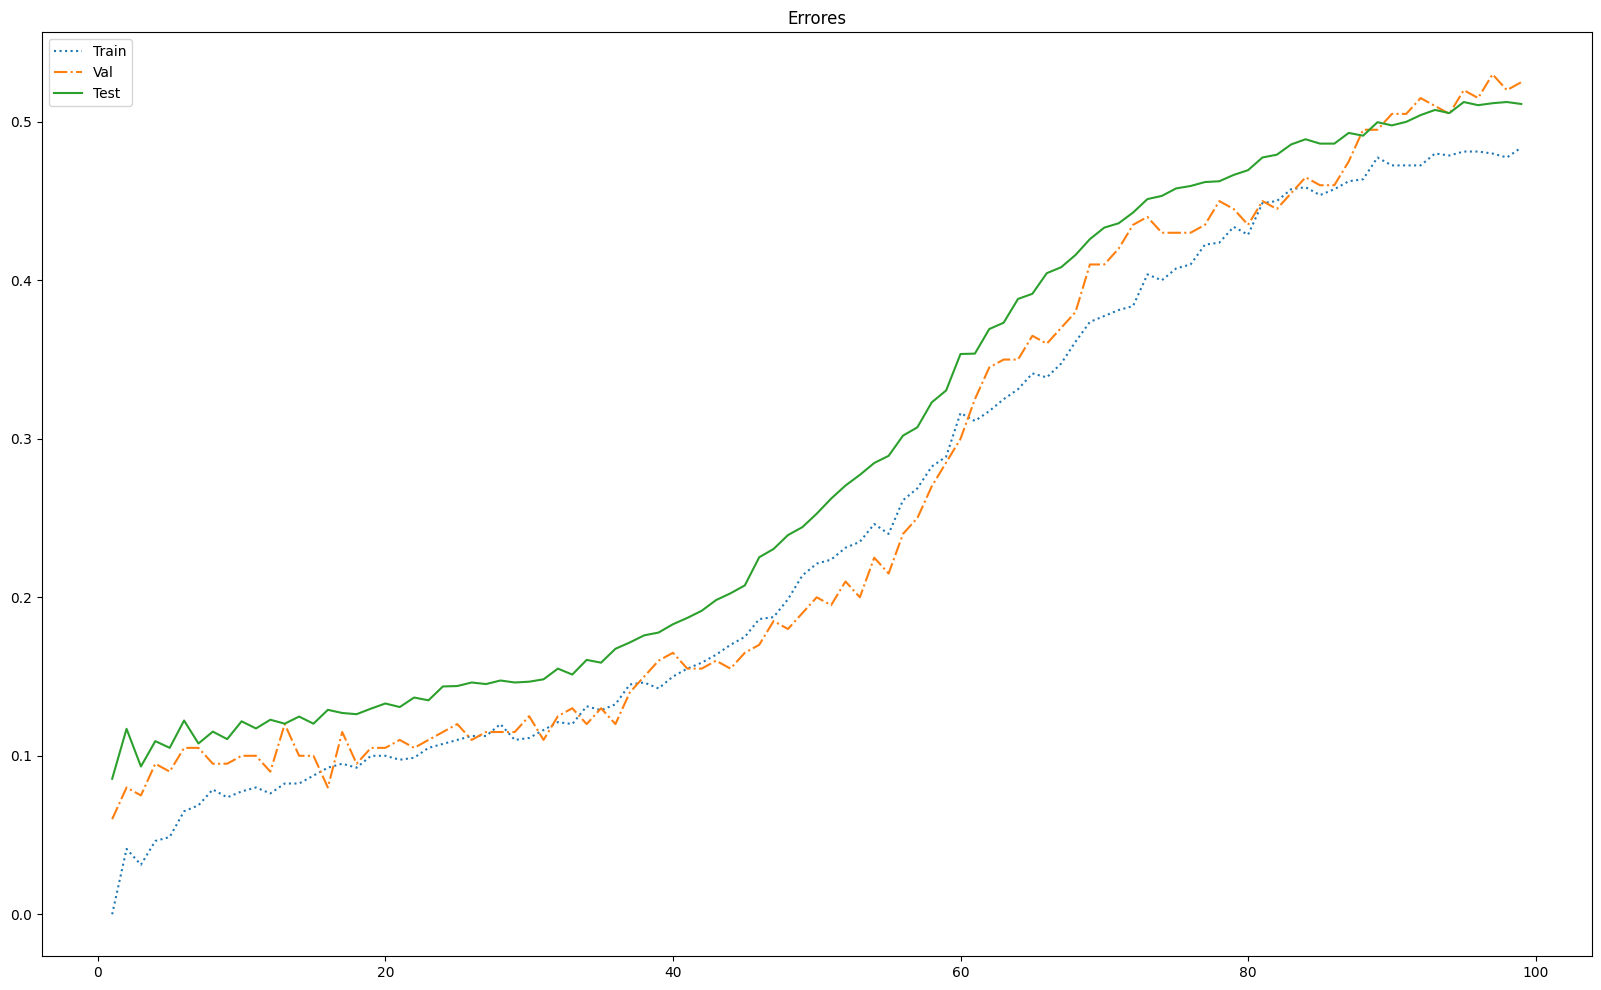

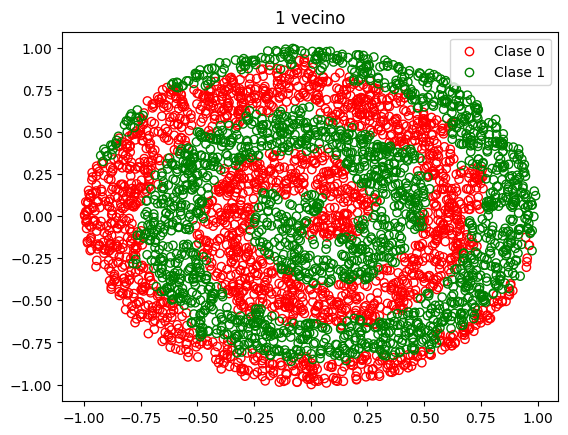

In [178]:
plotEntrenamiento2("Errores", errorsTrain, errorsVal, errorsTest, range(1, neighbors))

plotGrafico(f"{bestKNN.n_neighbors} vecino", xTest, bestKNN.predict(xTest))

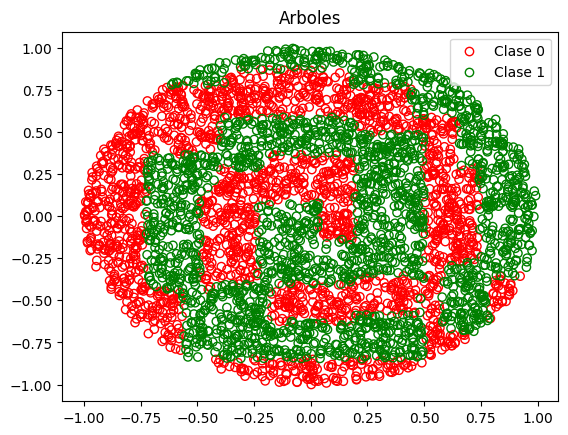

In [179]:
clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
clf.fit(xTrain, yTrain)

plotGrafico("Arboles", xTest, clf.predict(xTest))

Al no haber ruido en las muestras de espirales, si el número de vecinos es bajo, el interior de la espiral de cada clase debería predecirse perfectamente. Ahora bien, los límites de las espirales siempre serán un problema ya que estos puntos pueden llegar a estar tan cerca de los de su misma clase como de los de la otra. De cualquier manera, aquí tampoco es beneficioso un número de vecinos muy alto ya que podría comenzar a tener en cuenta puntos demasiado alejados que ya dejan de tener sentido tomarlos en cuenta para predecir la clase de la muestra.
Por lo tanto, tiene sentido que con una menor cantidad de vecinos se consiga una mejor predicción.

## Espirales con Ruido

In [99]:
data = pd.read_csv('./c_2.data', header=None, names=['1', '2', '3', '4', 'Target'])
test = pd.read_csv('./c_2.test', header=None, names=['1', '2', '3', '4', 'Target'])

xTrain, xVal, yTrain, yVal = train_test_split(data[['1', '2', '3', '4']].values, data['Target'].values, test_size=0.2)

xTest = test[['1', '2', '3', '4']].values
yTest = test['Target'].values

In [100]:
bestKNN, errorsTrain, errorsVal, errorsTest = entrenar_knn(KNeighborsClassifier(), neighbors, xTrain, yTrain, xVal, yVal, xTest, yTest)

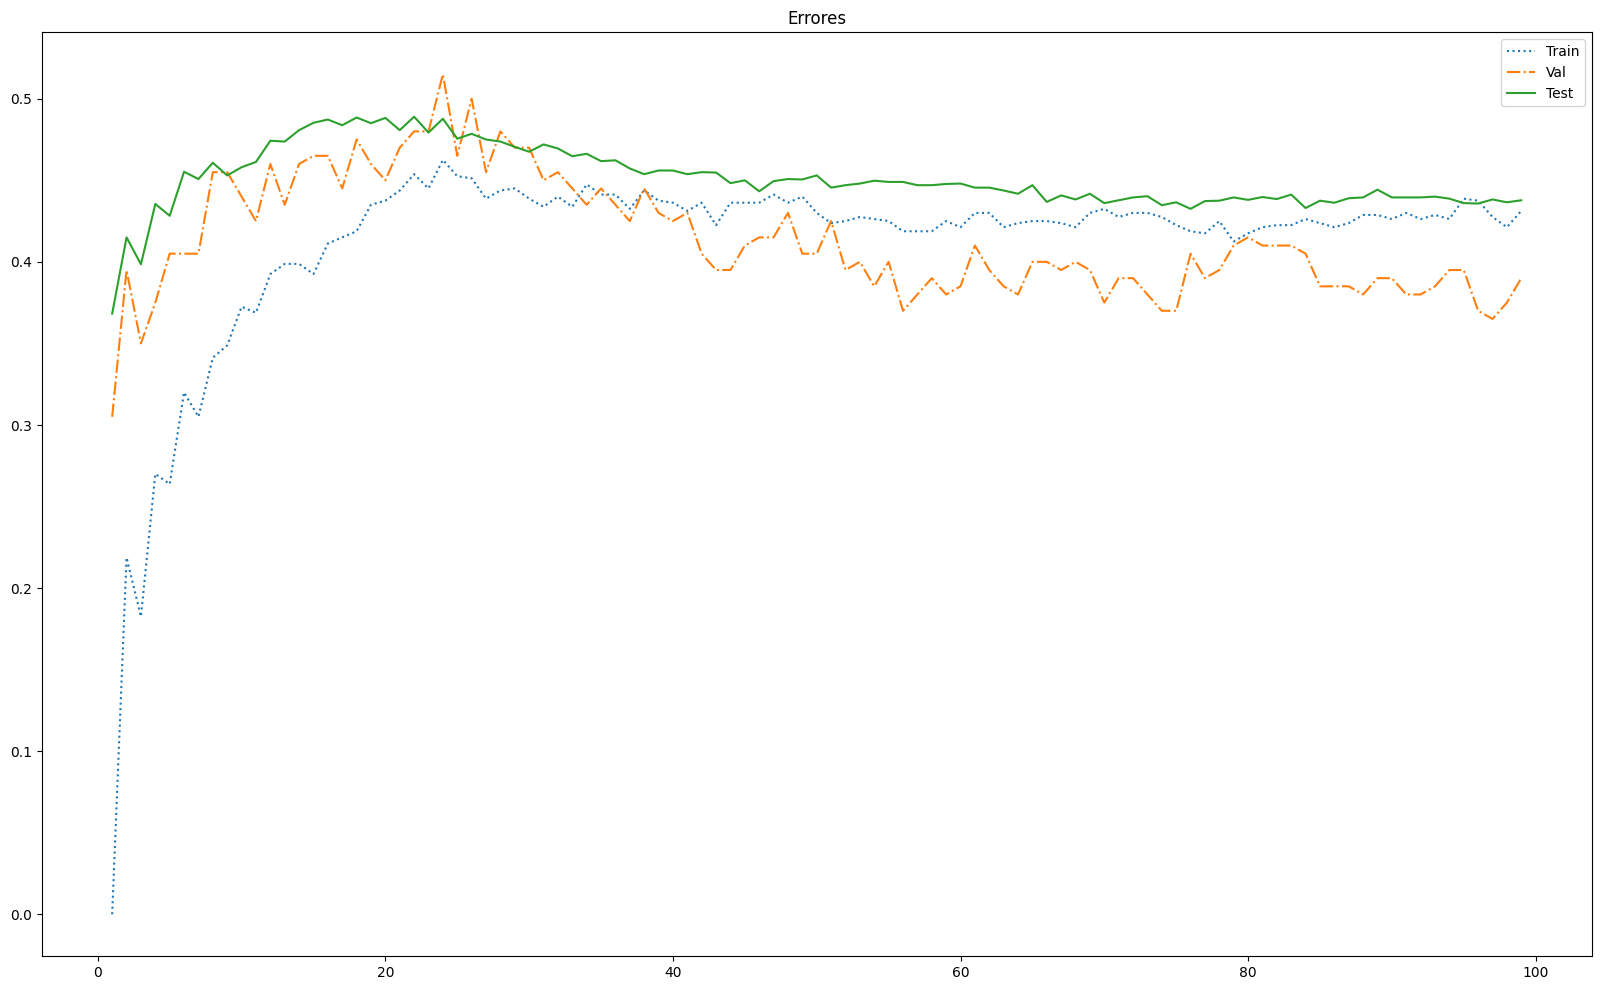

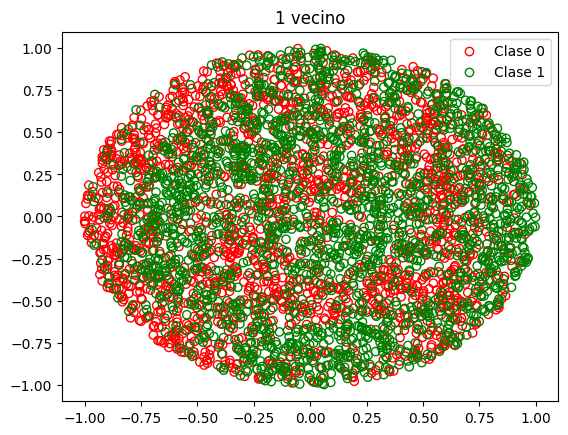

In [101]:
plotEntrenamiento2("Errores", errorsTrain, errorsVal, errorsTest, range(1, neighbors))

plotGrafico(f"{bestKNN.n_neighbors} vecino", test[['1', '2']].values, bestKNN.predict(xTest))

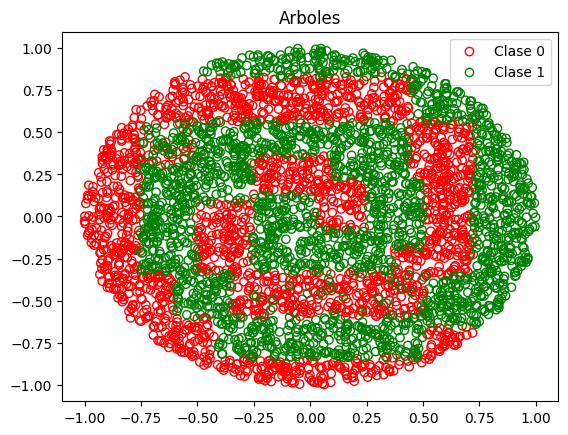

In [102]:
clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
clf.fit(xTrain, yTrain)

plotGrafico("Arboles", test[['1', '2']].values, clf.predict(xTest))

Al haber ruido en los espirales, uno inicialmente pensaría que una mayor cantidad de vecinos ayudaría para no confundirse con los datos ruidosos. Este no resultó ser el caso ya que, al haber tanto ruido, sigue siendo más probable que al ver al vecino más cercano, este pueda seguir prediciendo correctamente las clases. De esta manera, el mejor número de vecinos a evaluar sigue siendo 1. De cualquier manera, también podemos ver en el gráfico que los errores se van aplanando a diferencia del gráfico anterior. Por lo que supongo que si se aumenta el ruido en las muestras, aumentar el número de vecinos podría resultar beneficioso.

Ahora bien, como los árboles de decisión crean nuevas divisiones a partir de cierta ganancia de información, y dado que el ruido no es tan grande, esto no perjudicó su entrenamiento, por lo que ambos árboles consiguieron dar resultados bastante parecidos sin perder tanta precisión al agregar ruido.

# Ejercicio B

## Calculos

In [114]:
dimensiones = [2, 4, 8, 16, 32]
learning_rate = 0.1
momentum = 0.9
weight_decay = 10**(-4)
sub_epocas = 50
cant_epocas = 300
neuronas = 6
iterations = 20
neighbors = 100

errorPara = {}
errorDiag = {}
errorParaANN = {}
errorDiagANN = {}
errorParaNB = {}
errorDiagNB = {}
errorParaKO = {}
errorDiagKO = {}
errorParaK1 = {}
errorDiagK1 = {}

In [115]:
for i in dimensiones:
  test = diagonales(10000, i, 0.78)

  xTest = test[['d' + str(n + 1) for n in range(i)]].values
  yTest = test['Target'].values

  errorTree, errorANN, errorNB = [], [], []
  
  errorsI = [(0, 0, 0) for _ in range(neighbors - 1)]

  for _ in range(iterations):
    train = diagonales(250, i, 0.78)

    xTrain = train[['d' + str(n + 1) for n in range(i)]].values
    yTrain = train['Target'].values

    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    clf.fit(xTrain, yTrain)

    errorTree.append((1 - clf.score(xTrain, yTrain), 1 - clf.score(xTest, yTest)))

    clasif = MLPClassifier(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=weight_decay, batch_size=1, learning_rate='constant', learning_rate_init=learning_rate, 
                          momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epocas)
    
    _, error_train, error_test, _ = entrenar_red2(clasif, cant_epocas, xTrain, yTrain, xTest, yTest)

    errorANN.append((error_train[-1], error_test[-1]))

    clf = GaussianNB()

    clf.fit(xTrain, yTrain)

    errorNB.append((1 - clf.score(xTrain, yTrain), 1 - clf.score(xTest, yTest)))

    xTrain1, xVal, yTrain1, yVal = train_test_split(xTrain, yTrain, test_size=0.2)

    _, errorsTrain, errorsVal, errorsTest = entrenar_knn(KNeighborsClassifier(), neighbors, xTrain1, yTrain1, xVal, yVal, xTest, yTest)

    errorsI = [(errorsI[n][0] + (errorsTrain[n] / iterations), errorsI[n][1] + (errorsVal[n] / iterations), errorsI[n][2] + (errorsTest[n] / iterations)) for n in range(neighbors - 1)]


  errorDiag[i] = (np.average([x for x, y in errorTree]), np.average([y for x, y in errorTree]))
  errorDiagANN[i] = (np.average([x for x, y in errorANN]), np.average([y for x, y in errorANN]))
  errorDiagNB[i] = (np.average([x for x, y in errorNB]), np.average([y for x, y in errorNB]))
  
  errorsTrain, errorsTest = minError(errorsI)
  errorDiagKO[i] = minError(errorsI)

  errorDiagK1[i] = (errorsI[0][0], errorsI[0][2])

In [116]:
for i in dimensiones:
  test = paralelas(10000, i, 0.78)

  xTest = test[['d' + str(n + 1) for n in range(i)]].values
  yTest = test['Target'].values

  errorTree, errorANN, errorNB = [], [], []

  errorsI = [(0, 0, 0) for _ in range(neighbors - 1)]

  for _ in range(iterations):
    train = paralelas(250, i, 0.78)

    xTrain = train[['d' + str(n + 1) for n in range(i)]].values
    yTrain = train['Target'].values

    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    clf.fit(xTrain, yTrain)

    errorTree.append((1 - clf.score(xTrain, yTrain), 1 - clf.score(xTest, yTest)))

    clasif = MLPClassifier(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=weight_decay, batch_size=1, learning_rate='constant', learning_rate_init=learning_rate, 
                          momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epocas)
    
    _, error_train, error_test, _ = entrenar_red2(clasif, cant_epocas, xTrain, yTrain, xTest, yTest)

    errorANN.append((error_train[-1], error_test[-1]))

    clf = GaussianNB()

    clf.fit(xTrain, yTrain)

    errorNB.append((1 - clf.score(xTrain, yTrain), 1 - clf.score(xTest, yTest)))

    xTrain1, xVal, yTrain1, yVal = train_test_split(xTrain, yTrain, test_size=0.2)

    _, errorsTrain, errorsVal, errorsTest = entrenar_knn(KNeighborsClassifier(), neighbors, xTrain1, yTrain1, xVal, yVal, xTest, yTest)

    errorsI = [(errorsI[n][0] + (errorsTrain[n] / iterations), errorsI[n][1] + (errorsVal[n] / iterations), errorsI[n][2] + (errorsTest[n] / iterations)) for n in range(neighbors - 1)]

  errorPara[i] = (np.average([x for x, y in errorTree]), np.average([y for x, y in errorTree]))
  errorParaANN[i] = (np.average([x for x, y in errorANN]), np.average([y for x, y in errorANN]))
  errorParaNB[i] = (np.average([x for x, y in errorNB]), np.average([y for x, y in errorNB]))

  errorParaKO[i] = minError(errorsI)

  errorParaK1[i] = (errorsI[0][0], errorsI[0][2])

## Graficos

In [118]:
errDiagArbol = ([v[0] for k, v in errorDiag.items()], [v[1] for k, v in errorDiag.items()])
errParaArbol = ([v[0] for k, v in errorPara.items()], [v[1] for k, v in errorPara.items()])
errDiagANN = ([v[0] for k, v in errorDiagANN.items()], [v[1] for k, v in errorDiagANN.items()])
errParaANN = ([v[0] for k, v in errorParaANN.items()], [v[1] for k, v in errorParaANN.items()])
errDiagNB = ([v[0] for k, v in errorDiagNB.items()], [v[1] for k, v in errorDiagNB.items()])
errParaNB = ([v[0] for k, v in errorParaNB.items()], [v[1] for k, v in errorParaNB.items()])
errDiagKO = ([v[0] for k, v in errorDiagKO.items()], [v[1] for k, v in errorDiagKO.items()])
errParaKO = ([v[0] for k, v in errorParaKO.items()], [v[1] for k, v in errorParaKO.items()])
errDiagK1 = ([v[0] for k, v in errorDiagK1.items()], [v[1] for k, v in errorDiagK1.items()])
errParaK1 = ([v[0] for k, v in errorParaK1.items()], [v[1] for k, v in errorParaK1.items()])

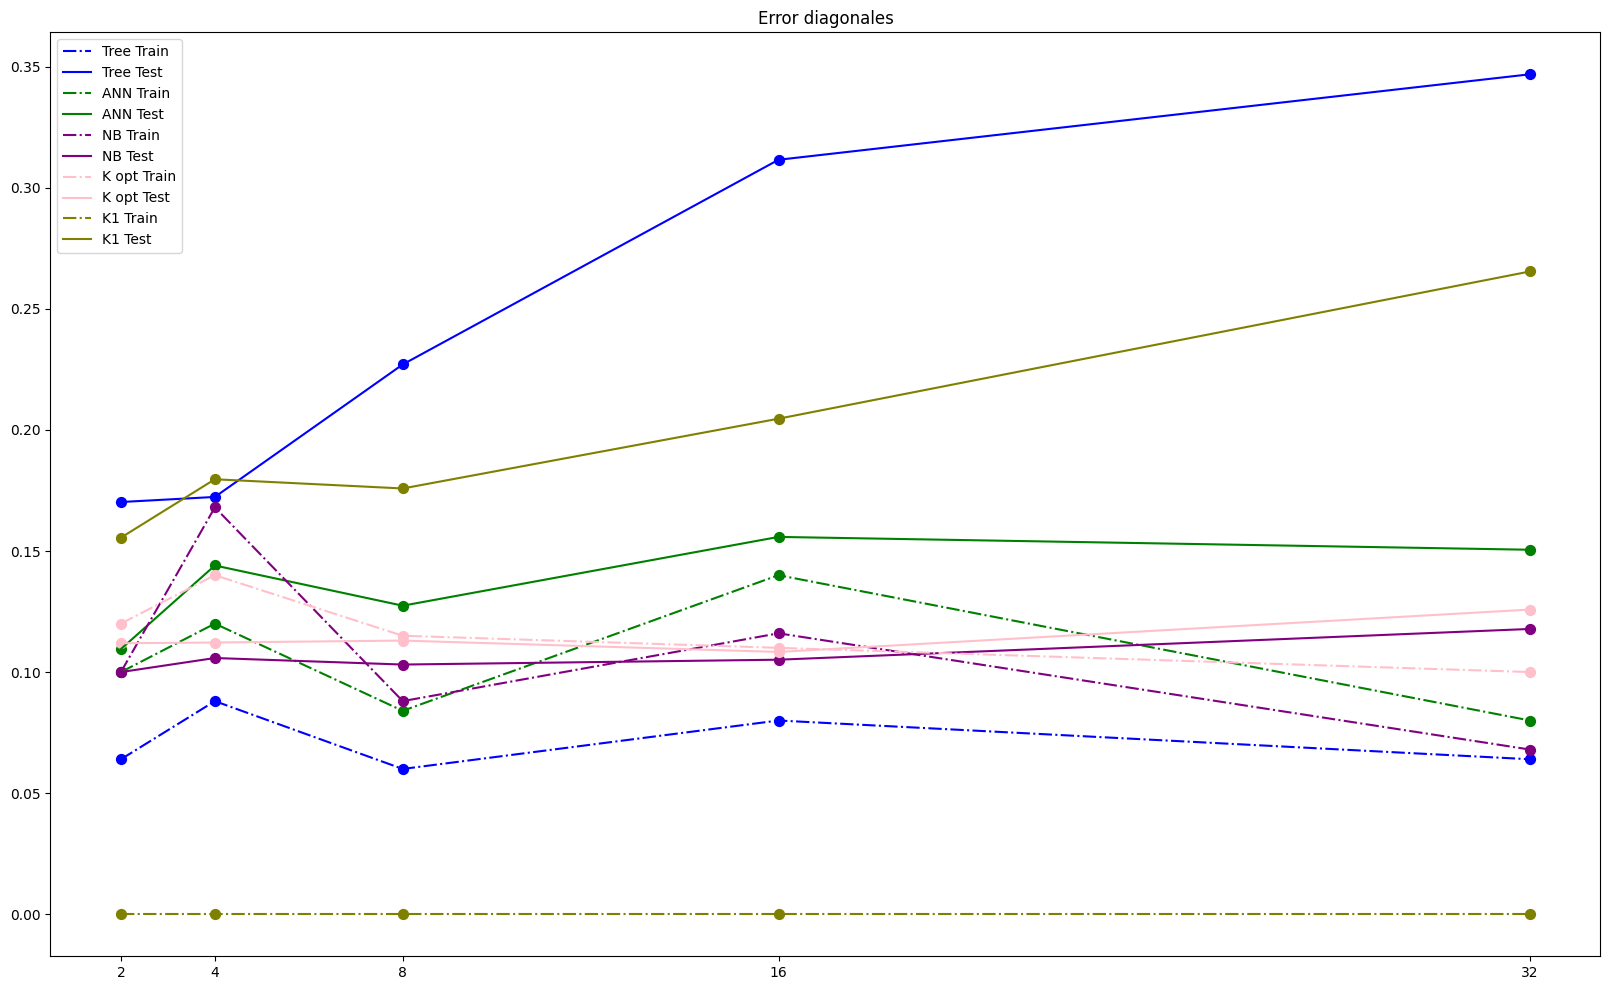

In [117]:
plotEntrenamiento3("Error diagonales", errDiagArbol, errDiagANN, errDiagNB, errDiagKO, errDiagK1, dimensiones)

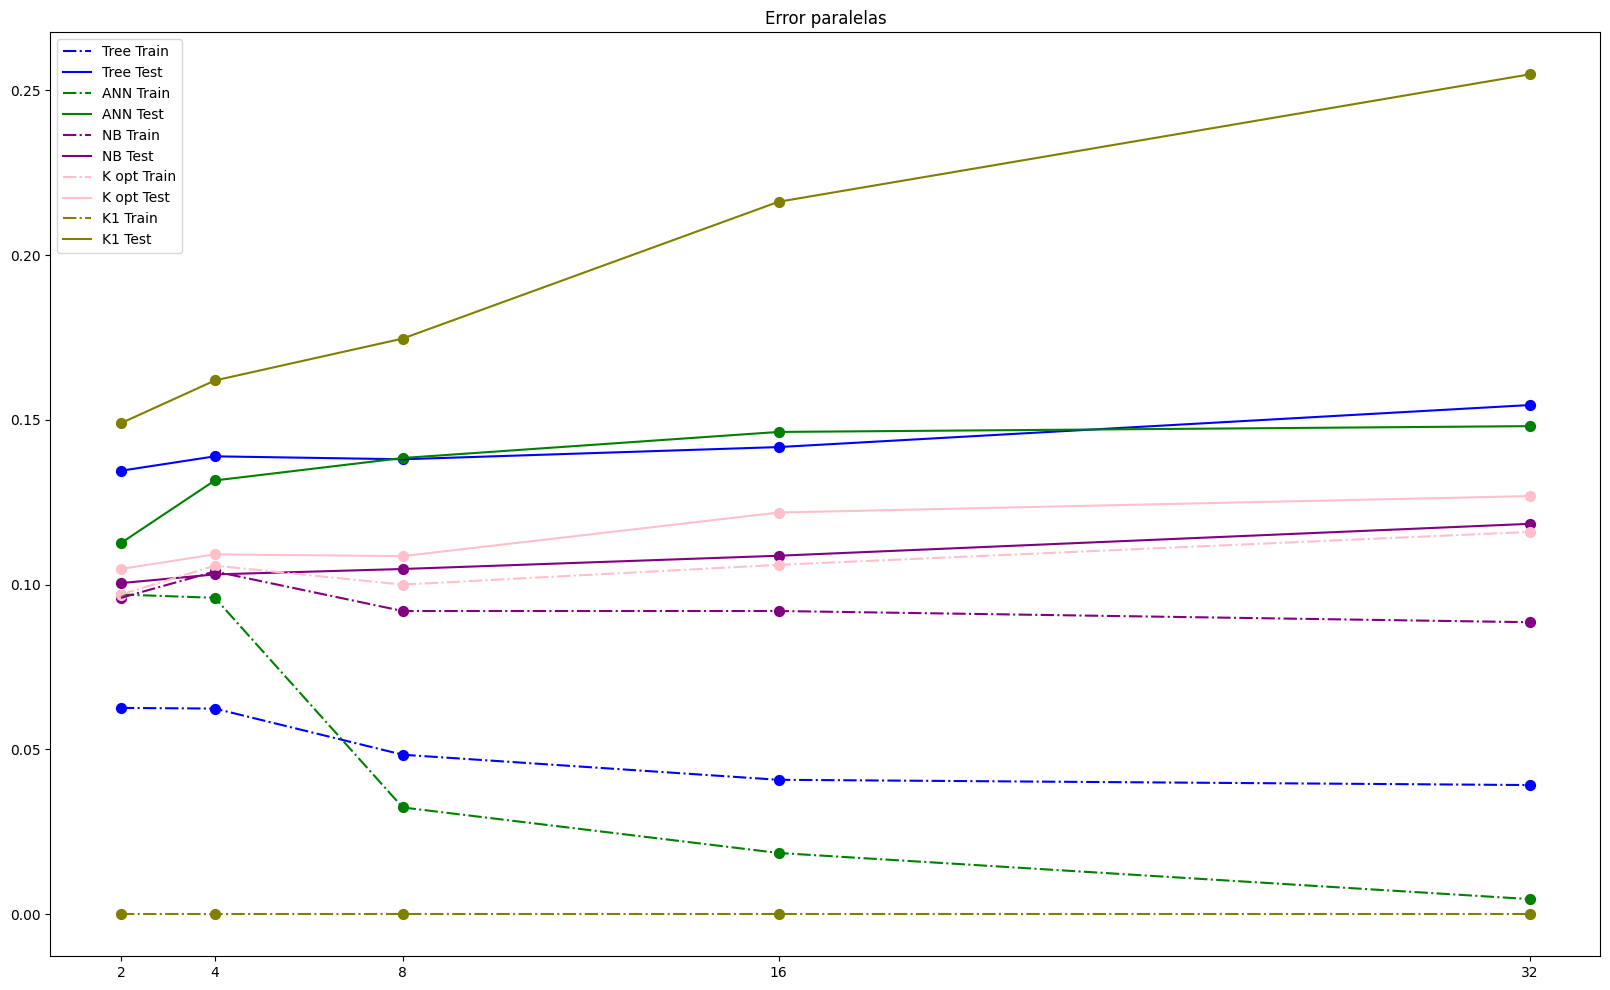

In [119]:
plotEntrenamiento3("Error paralelas", errParaArbol, errParaANN, errParaNB, errParaKO, errParaK1, dimensiones)

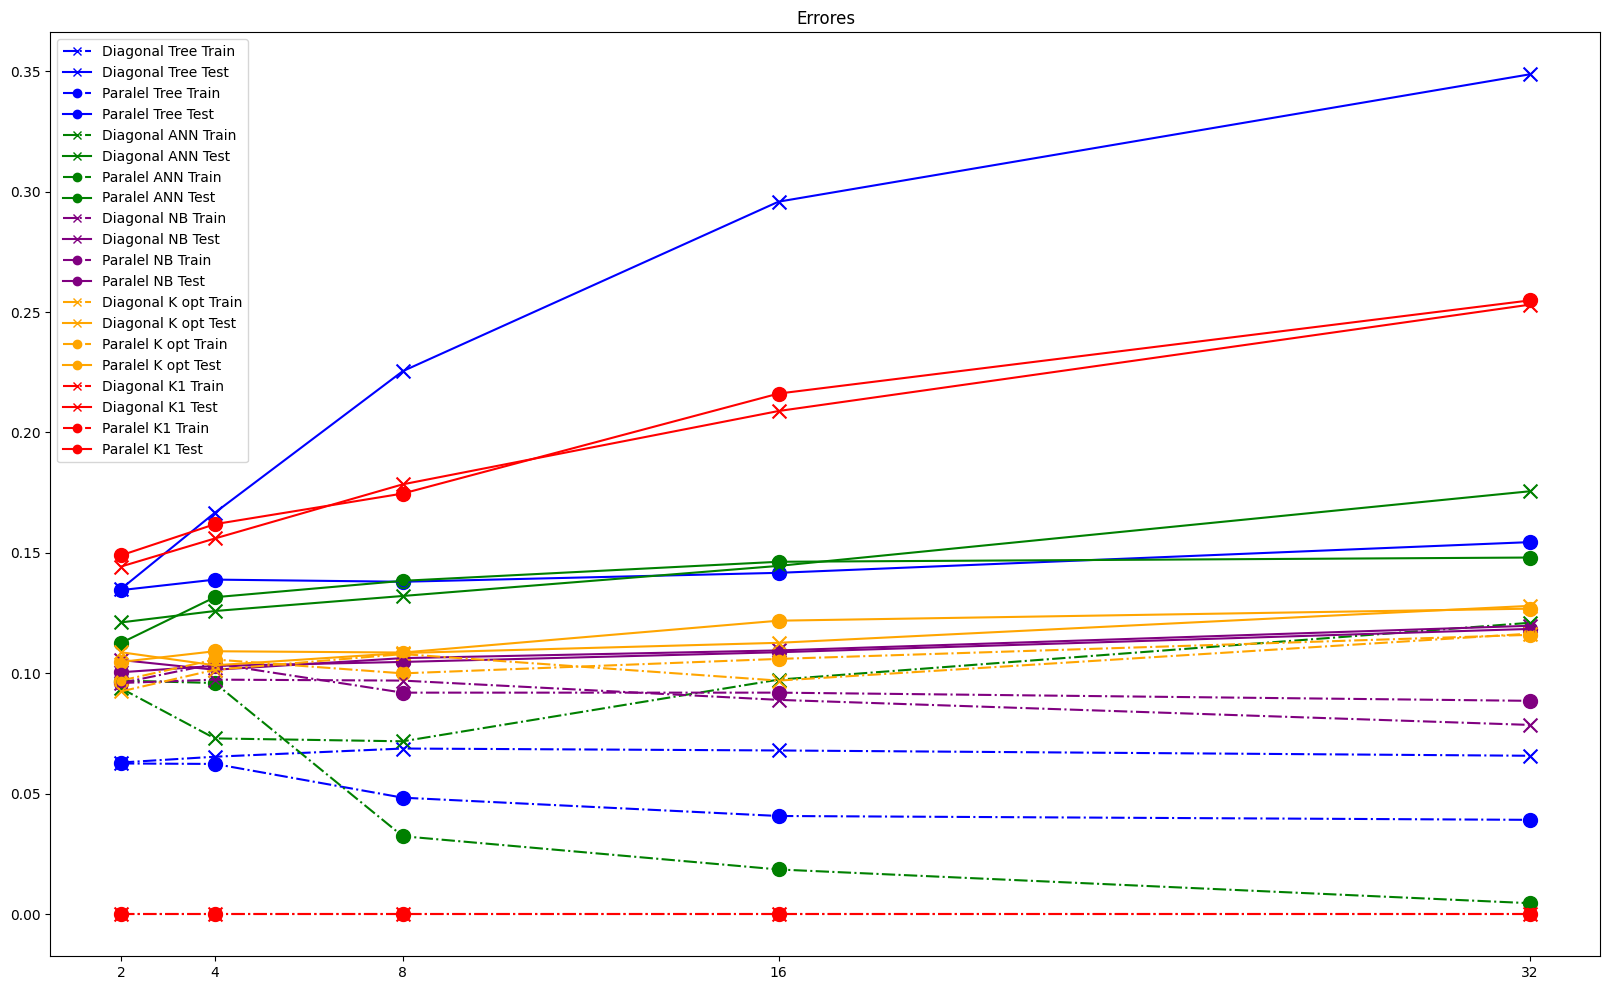

In [120]:
plotEntrenamiento4("Errores", errDiagArbol, errParaArbol, errDiagANN, errParaANN, errDiagNB, errParaNB, errDiagKO, errParaKO, errDiagK1, errParaK1, dimensiones)

## Comentarios

El testeo teniendo en cuenta a solo un vecino resultó ser mucho peor que el óptimo. Esto se debe a que en el espacio donde se presenta ruido, donde ambas distribuciones colapsan, se tendría en cuenta a un único vecino, mientras que si se tuvieran en cuenta varios más, se podría obtener una mejor predicción ya que, al ser distribuciones gaussianas, la clase de la muestra tendería a ser la del centro (la clase) más cercano. Justamente esto sucedió con el K óptimo. Aquí hice 20 intentos con cada k, y elegí el k con mejor promedio para usar en cada número de dimensiones. Se puede ver también cómo con este K óptimo se llegó casi a la misma tasa de errores que en Naive-Bayes, la cual tiende a mostrar el error mínimo conseguible.
Cabe aclarar que el entrenamiento con K=1 siempre dará error 0, ya que las muestras caerán siempre sobre los mismos puntos sobre los cuales se entrenó.
Además, la diferencia entre errores de entrenamiento y testeo de K óptimo es mucho menor que la de Naive-Bayes, lo que nos muestra una clara ausencia de sobreentrenamiento.

# Ejercicio C

In [121]:
neighbors = 100

## 32 dimensiones

### Diagonales

In [122]:
test = diagonales(10000, 32, 0.78)

xTest = test[['d' + str(n + 1) for n in range(32)]].values
yTest = test['Target'].values

train = diagonales(200, 32, 0.78)
xTrain = train[['d' + str(n + 1) for n in range(32)]].values
yTrain = train['Target'].values

val = diagonales(50, 32, 0.78)
xVal = val[['d' + str(n + 1) for n in range(32)]].values
yVal = val['Target'].values

In [123]:
_, errorsTrain, errorsVal, errorsTest = entrenar_knn(KNeighborsClassifier(weights='distance'), neighbors, xTrain, yTrain, xVal, yVal, xTest, yTest)

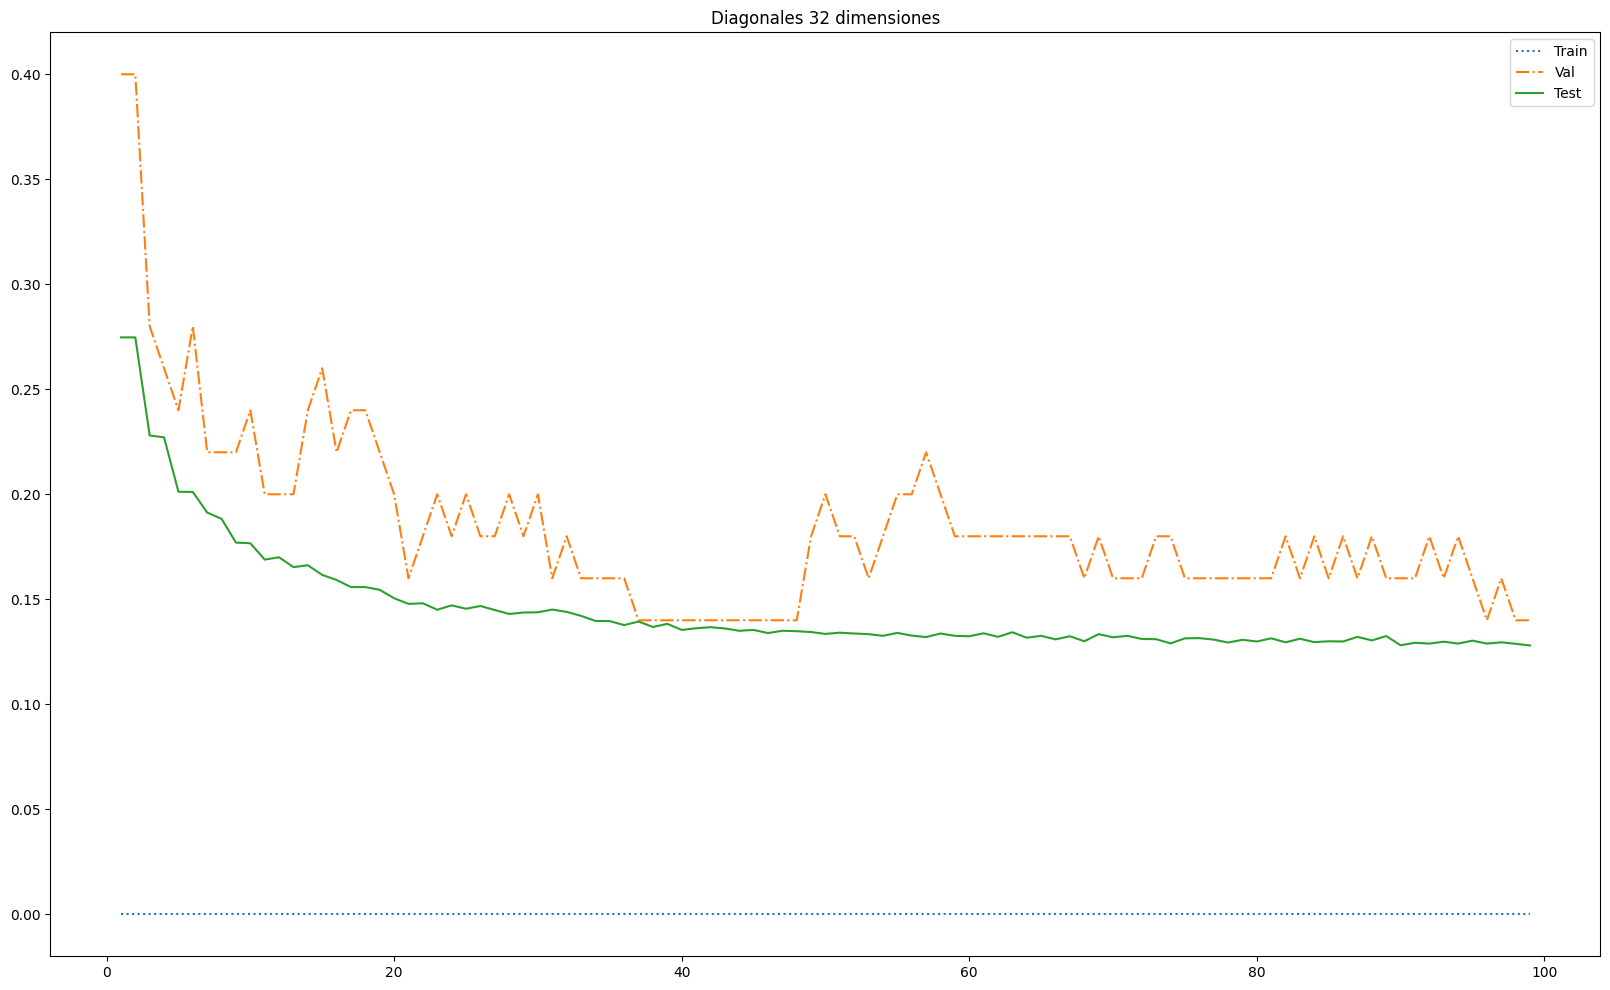

In [124]:
plotEntrenamiento2("Diagonales 32 dimensiones", errorsTrain, errorsVal, errorsTest, range(1, neighbors))

### Paralelas

In [125]:
test = paralelas(10000, 32, 0.78)

xTest = test[['d' + str(n + 1) for n in range(32)]].values
yTest = test['Target'].values

train = paralelas(200, 32, 0.78)
xTrain = train[['d' + str(n + 1) for n in range(32)]].values
yTrain = train['Target'].values

val = paralelas(50, 32, 0.78)
xVal = val[['d' + str(n + 1) for n in range(32)]].values
yVal = val['Target'].values

In [126]:
_, errorsTrain, errorsVal, errorsTest = entrenar_knn(KNeighborsClassifier(weights='distance'), neighbors, xTrain, yTrain, xVal, yVal, xTest, yTest)

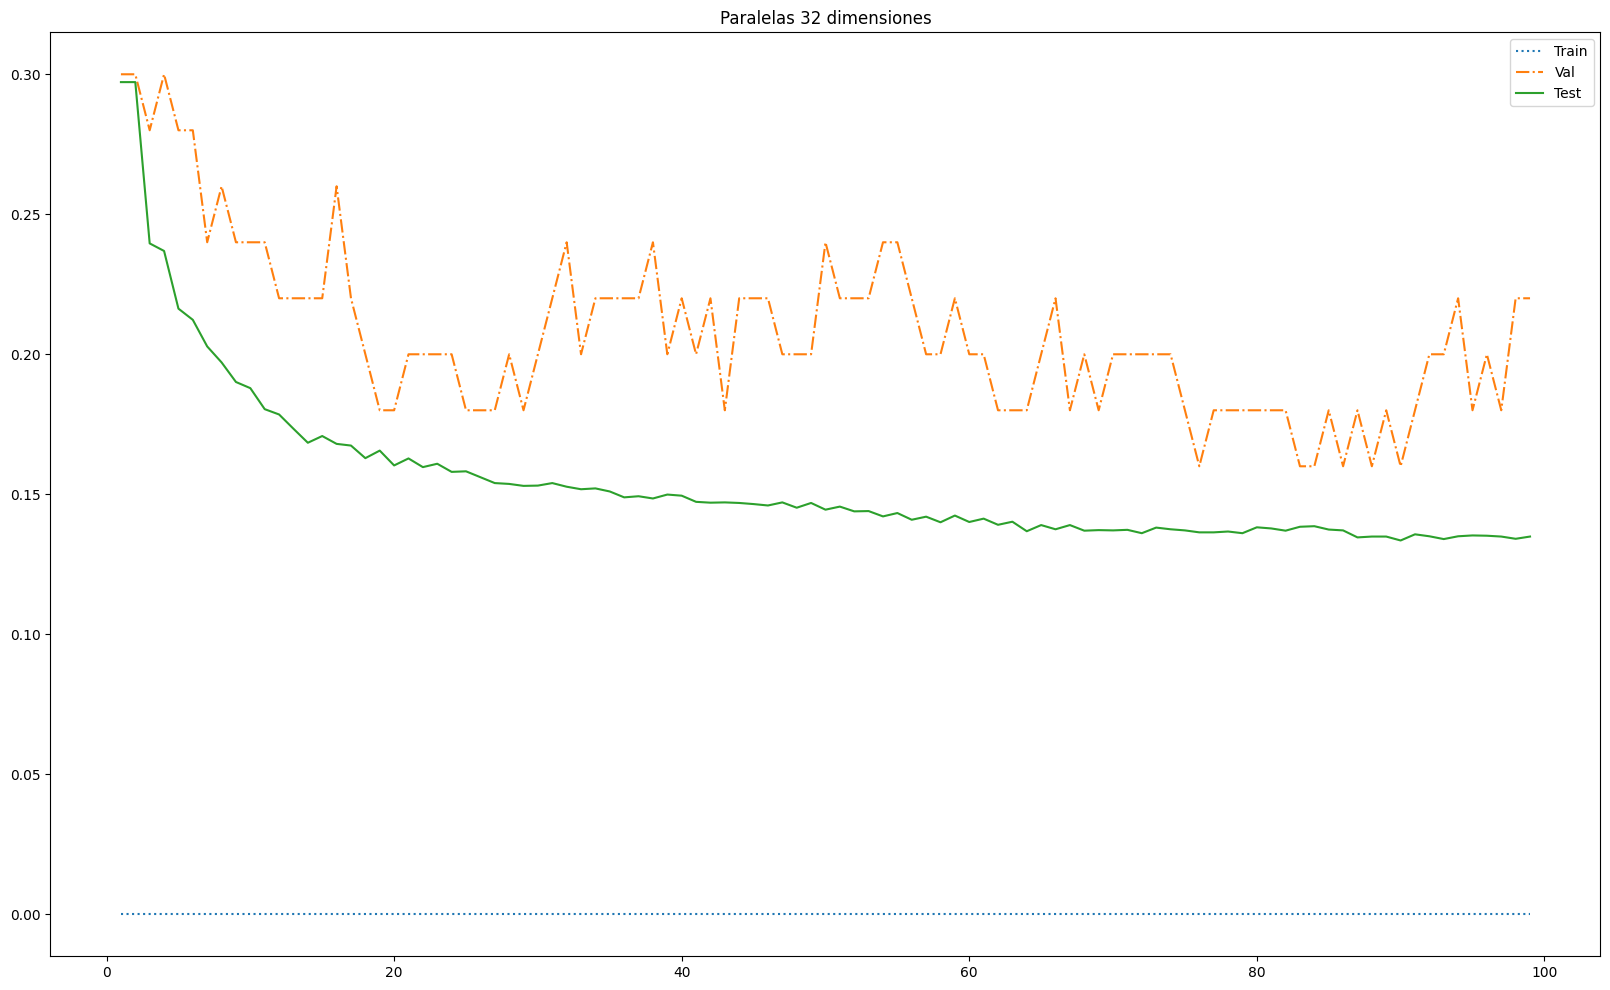

In [127]:
plotEntrenamiento2("Paralelas 32 dimensiones", errorsTrain, errorsVal, errorsTest, range(1, neighbors))

### Comentarios

Al estar teniendo en cuenta la distancia a la que están los puntos, aumentar el K no resulta ser un problema ya que un punto tenderá a estar más cerca de los de su clase que de los de la otra siempre que esté más cerca de su centro. Esto servirá ya que los tendrá mucho más en cuenta que a los puntos más lejanos. Cuando esté más cerca del otro centro, justamente esos casos son los que son imposibles de predecir correctamente y en este caso se predecirá como la otra clase.
Cabe aclarar que, si no se tuviera en cuenta la distancia a los puntos, mientras más grande sea K, más tendería a un error de 0.5 debido a que hay la misma cantidad de puntos de cada clase.

También, se puede ver en ambos gráficos que, a partir de un número dado de vecinos, ya no se consigue una mejoría muy notoria (20 en diagonales y 40 en paralelas). Esto se debe a que, al aumentar el número de vecinos a tener en cuenta, la distancia también sube junto a estos, y de esta manera su valor se tiene menos en cuenta por estar cada vez más lejos de la muestra.

Un dato más a tener en cuenta es que en ambos gráficos el error de entrenamiento es de 0. Esto se da porque al haber sido entrenado por ese mismo conjunto, y como se están usando pesos por distancia inversa, al caer la muestra sobre el mismo punto que se entrenó, el valor que se calcula sobre ese punto de entrenamiento tiende a infinito (al ser la distancia 0) y la muestra pasa a tener su misma clase (provocando un error de 0 en el entrenamiento).

## Dimensiones

In [128]:
dimentions = [2, 4, 8, 16, 32]

### Calculos

In [129]:
iterations = 20

errorParaKO = {}
errorDiagKO = {}
errorParaK1 = {}
errorDiagK1 = {}
errorParaKOW = {}
errorDiagKOW = {}
errorParaK50W = {}
errorDiagK50W = {}

In [130]:
for i in dimentions:
    test = diagonales(10000, i, 0.78)

    xTest = test[['d' + str(n + 1) for n in range(i)]].values
    yTest = test['Target'].values

    errorsI = [(0, 0, 0) for _ in range(neighbors - 1)]
    errorsIW = [(0, 0, 0) for _ in range(neighbors - 1)]

    for _ in range(iterations):
        train = diagonales(200, i, 0.78)
        xTrain = train[['d' + str(n + 1) for n in range(i)]].values
        yTrain = train['Target'].values

        val = diagonales(50, i, 0.78)
        xVal = val[['d' + str(n + 1) for n in range(i)]].values
        yVal = val['Target'].values

        _, errorsTrain, errorsVal, errorsTest = entrenar_knn(KNeighborsClassifier(), neighbors, xTrain, yTrain, xVal, yVal, xTest, yTest)

        errorsI = [(errorsI[n][0] + (errorsTrain[n] / iterations), errorsI[n][1] + (errorsVal[n] / iterations), errorsI[n][2] + (errorsTest[n] / iterations)) for n in range(neighbors - 1)]

        _, errorsTrain, errorsVal, errorsTest = entrenar_knn(KNeighborsClassifier(weights='distance'), neighbors, xTrain, yTrain, xVal, yVal, xTest, yTest)

        errorsIW = [(errorsIW[n][0] + (errorsTrain[n] / iterations), errorsIW[n][1] + (errorsVal[n] / iterations), errorsIW[n][2] + (errorsTest[n] / iterations)) for n in range(neighbors - 1)]

    errorDiagKO[i] = minError(errorsI)
    errorDiagK1[i] = (errorsI[0][0], errorsI[0][2])
    
    errorDiagKOW[i] = minError(errorsIW)
    errorDiagK50W[i] = (errorsIW[49][0], errorsIW[49][2])

In [131]:
for i in dimentions:
    test = paralelas(10000, i, 0.78)

    xTest = test[['d' + str(n + 1) for n in range(i)]].values
    yTest = test['Target'].values

    errorsI = [(0, 0, 0) for _ in range(neighbors - 1)]
    errorsIW = [(0, 0, 0) for _ in range(neighbors - 1)]

    for _ in range(iterations):
        train = paralelas(200, i, 0.78)
        xTrain = train[['d' + str(n + 1) for n in range(i)]].values
        yTrain = train['Target'].values

        val = paralelas(50, i, 0.78)
        xVal = val[['d' + str(n + 1) for n in range(i)]].values
        yVal = val['Target'].values

        _, errorsTrain, errorsVal, errorsTest = entrenar_knn(KNeighborsClassifier(), neighbors, xTrain, yTrain, xVal, yVal, xTest, yTest)

        errorsI = [(errorsI[n][0] + (errorsTrain[n] / iterations), errorsI[n][1] + (errorsVal[n] / iterations), errorsI[n][2] + (errorsTest[n] / iterations)) for n in range(neighbors - 1)]

        _, errorsTrain, errorsVal, errorsTest = entrenar_knn(KNeighborsClassifier(weights='distance'), neighbors, xTrain, yTrain, xVal, yVal, xTest, yTest)

        errorsIW = [(errorsIW[n][0] + (errorsTrain[n] / iterations), errorsIW[n][1] + (errorsVal[n] / iterations), errorsIW[n][2] + (errorsTest[n] / iterations)) for n in range(neighbors - 1)]

    errorParaKO[i] = minError(errorsI)
    errorParaK1[i] = (errorsI[0][0], errorsI[0][2])
    
    errorParaKOW[i] = minError(errorsIW)
    errorParaK50W[i] = (errorsIW[49][0], errorsIW[49][2])

### Grafico

In [152]:
errDiagKO = ([v[0] for k, v in errorDiagKO.items()], [v[1] for k, v in errorDiagKO.items()])
errParaKO = ([v[0] for k, v in errorParaKO.items()], [v[1] for k, v in errorParaKO.items()])
errDiagK1 = ([v[0] for k, v in errorDiagK1.items()], [v[1] for k, v in errorDiagK1.items()])
errParaK1 = ([v[0] for k, v in errorParaK1.items()], [v[1] for k, v in errorParaK1.items()])
errDiagKOW = ([v[0] for k, v in errorDiagKOW.items()], [v[1] for k, v in errorDiagKOW.items()])
errParaKOW = ([v[0] for k, v in errorParaKOW.items()], [v[1] for k, v in errorParaKOW.items()])
errDiagK50W = ([v[0] for k, v in errorDiagK50W.items()], [v[1] for k, v in errorDiagK50W.items()])
errParaK50W = ([v[0] for k, v in errorParaK50W.items()], [v[1] for k, v in errorParaK50W.items()])

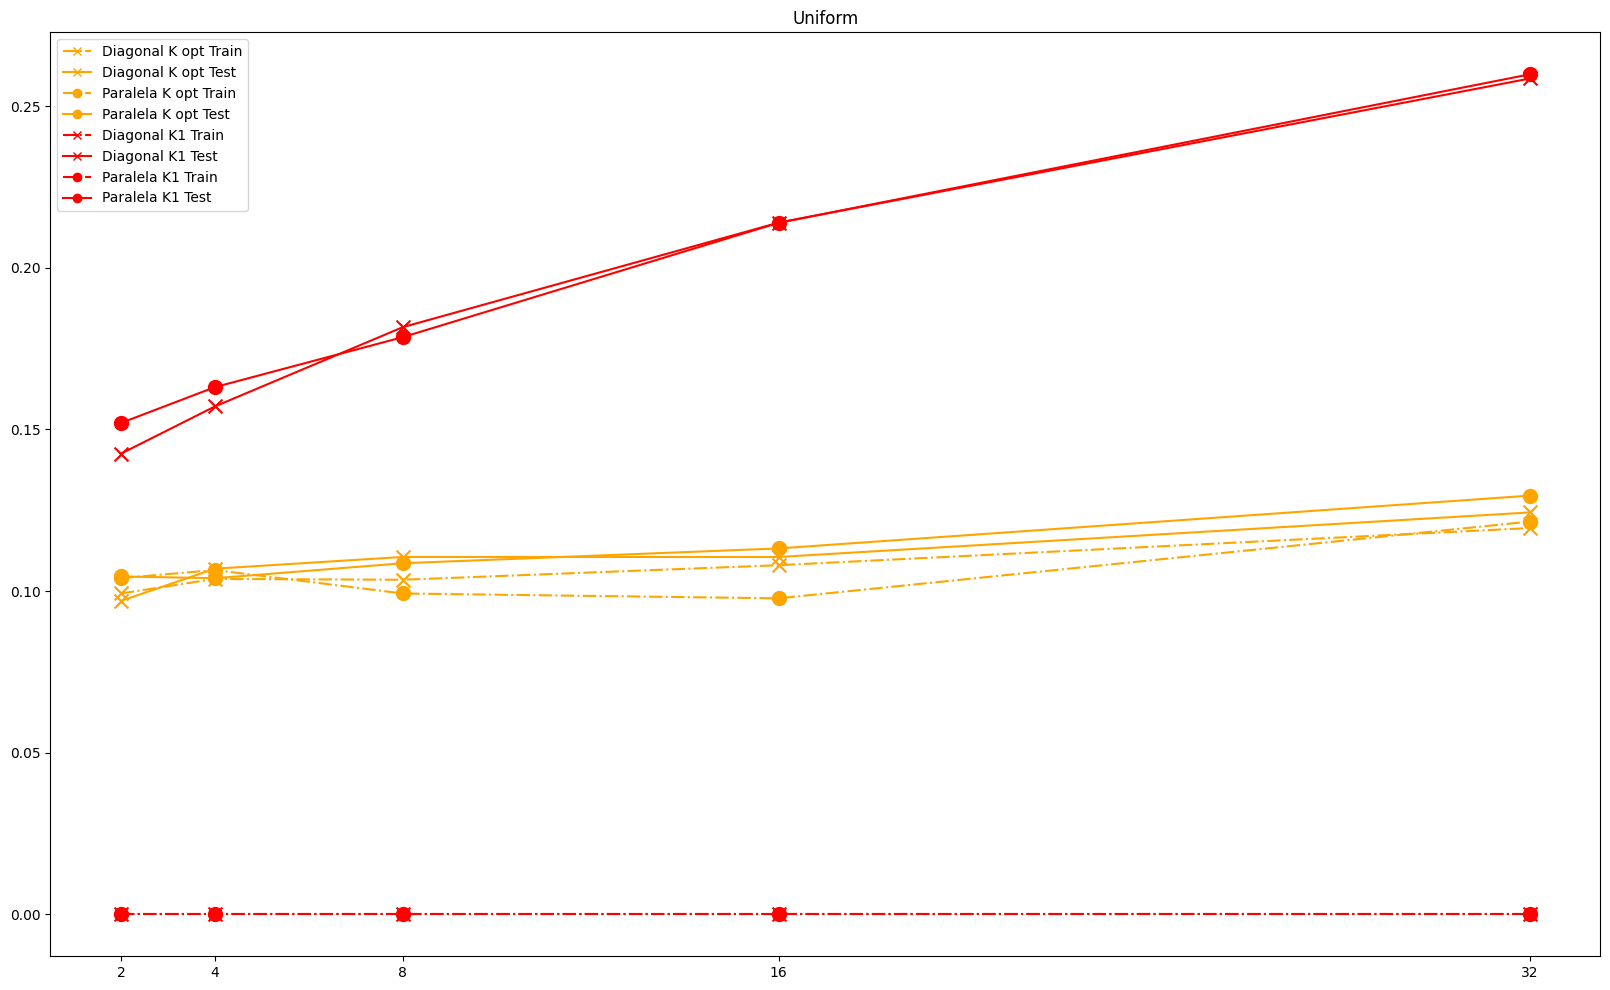

In [176]:
plotEntrenamiento6("Uniform", errDiagKO, errParaKO, errDiagK1, errParaK1, dimentions)

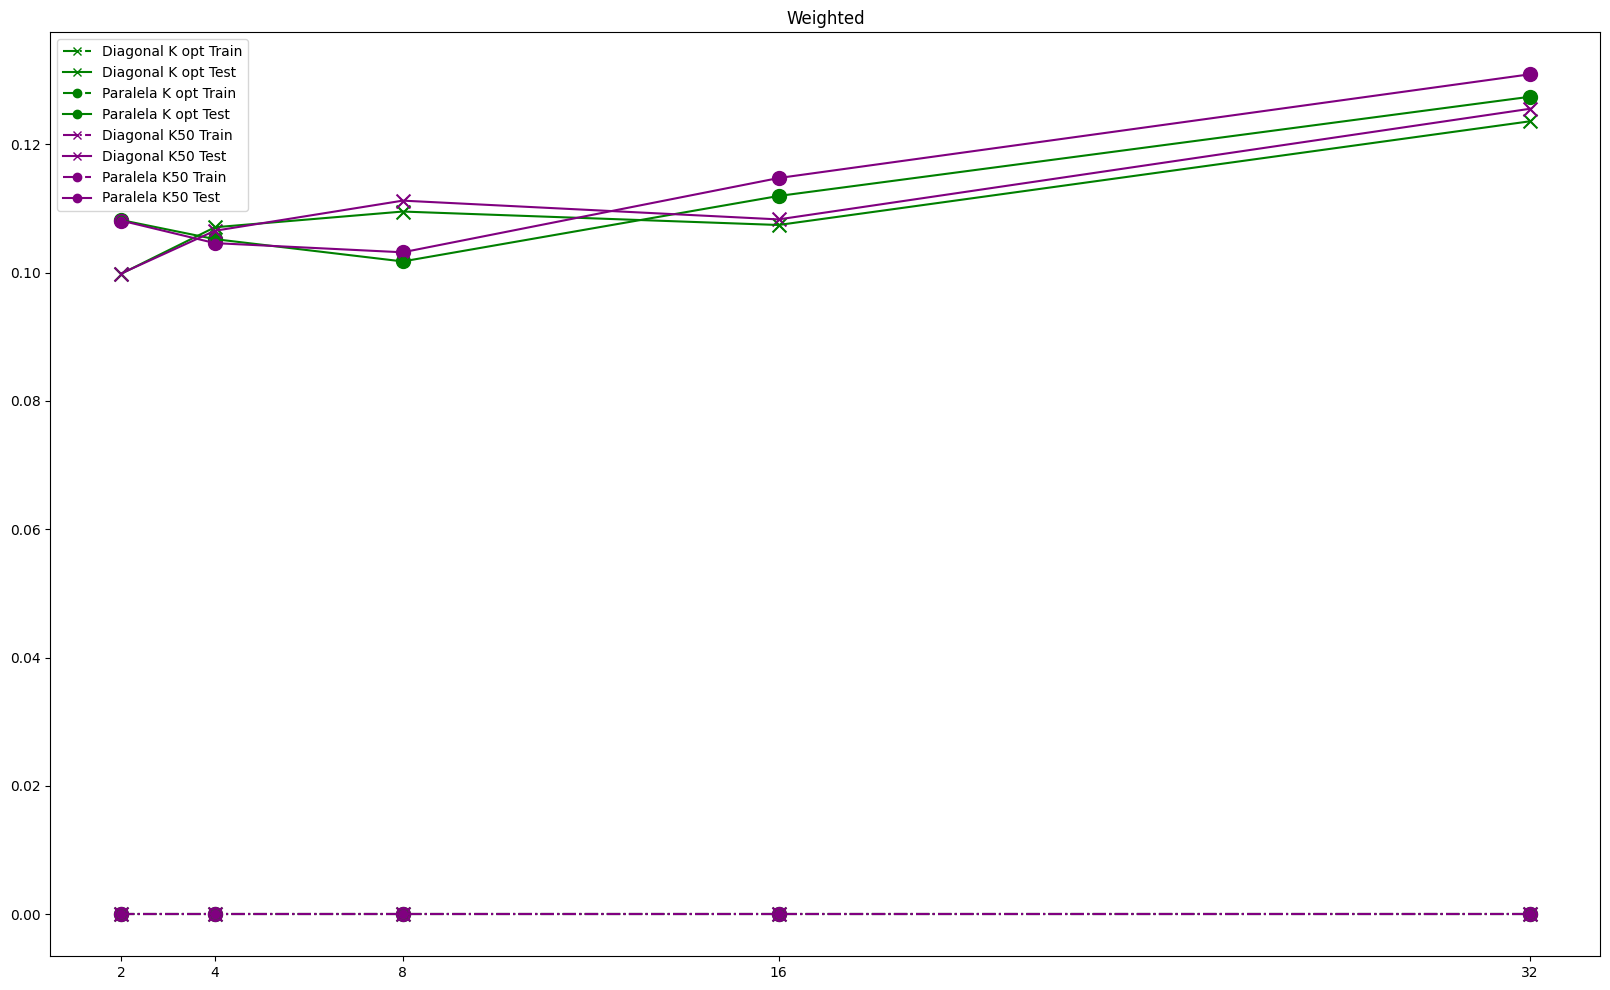

In [177]:
plotEntrenamiento7("Weighted", errDiagKOW, errParaKOW, errDiagK50W, errParaK50W, dimentions)

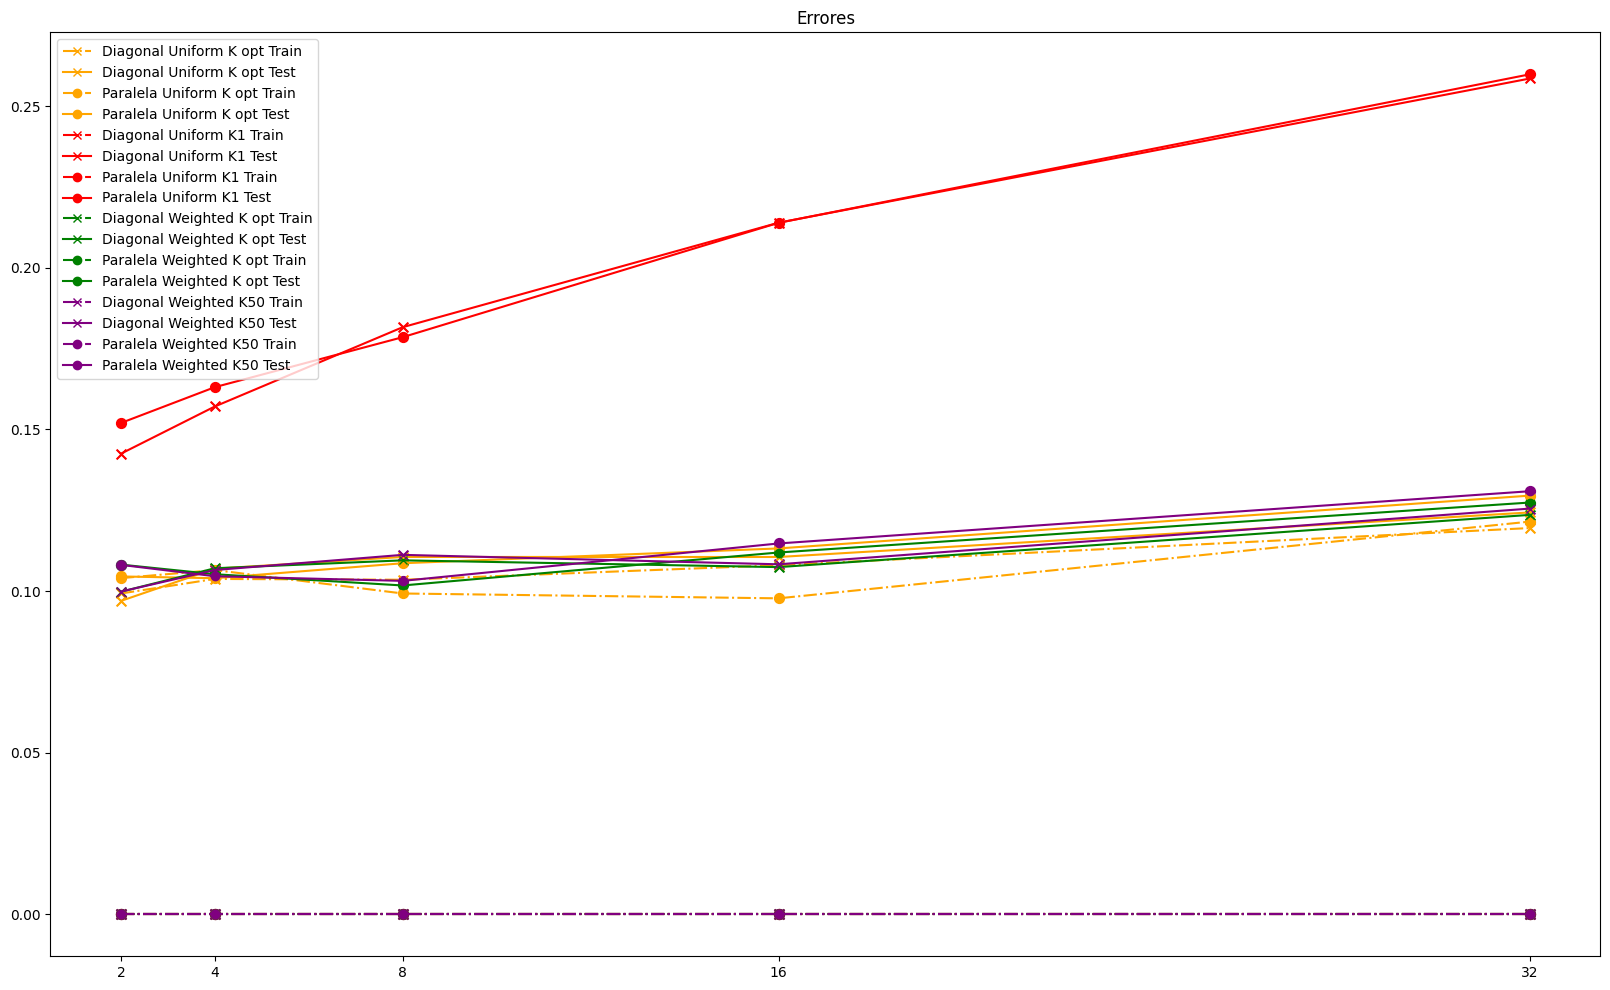

In [178]:
plotEntrenamiento5("Errores", errDiagKO, errParaKO, errDiagK1, errParaK1, errDiagKOW, errParaKOW, errDiagK50W, errParaK50W, dimentions)

### Comentarios

Fuera del caso de K=1 Uniforme, tener en cuenta la distancia hasta los puntos no resultó en una mejoría de los errores (de testeo). Aunque realmente, al estar estos tan cerca del error mínimo a predecir, no se podría haber conseguido ninguna mejoría notable.

También, como se pudo ver en el gráfico de 32 dimensiones, probar con más de 50 vecinos no resulta en una gran mejoría. De esta manera, aunque en varias dimensiones se tuvo un menor error con el número óptimo de vecinos, este error no cambió tanto en comparación con usar 50 vecinos.

# Ejercicio D

## Sunspots

In [27]:
data = pd.read_csv('./ssp.data', header=None, names=([str(n) for n in range(12)] + ['Target']))
test = pd.read_csv('./ssp.test', header=None, names=([str(n) for n in range(12)] + ['Target']))

xData = data[[str(n) for n in range(12)]].values
yData = data['Target'].values

xTrain, xVal, yTrain, yVal = train_test_split(xData, yData, test_size=0.2)

xTest = test[[str(n) for n in range(12)]].values
yTest = test['Target'].values

### KNN

In [28]:
neighbors = 100

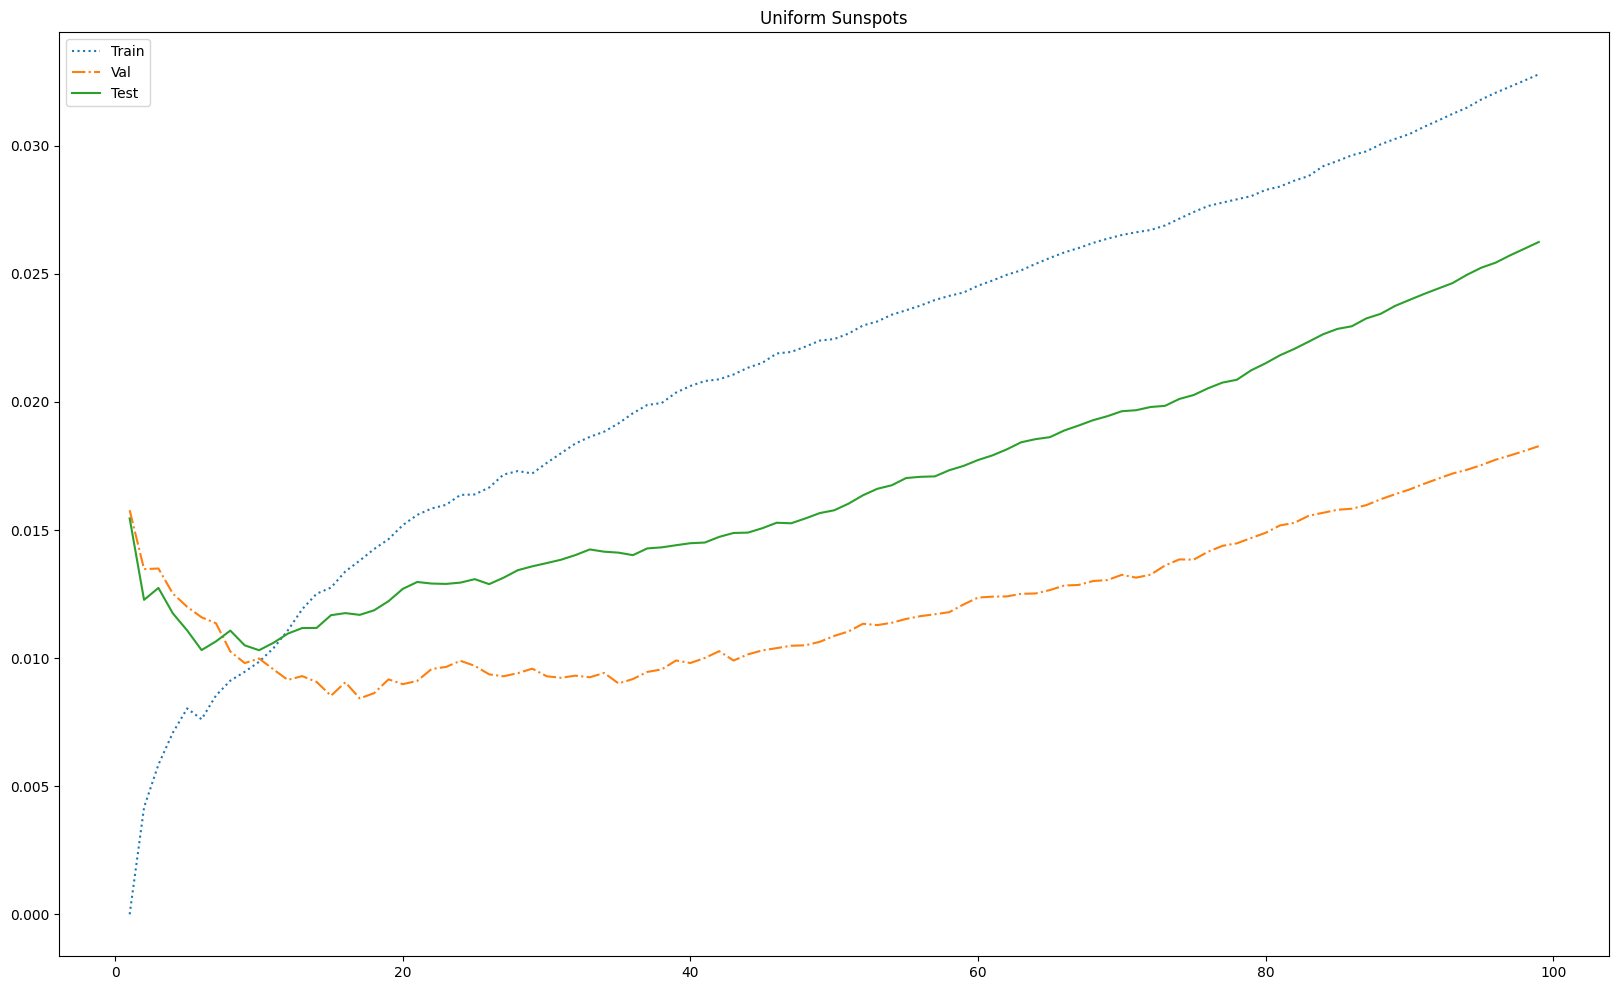

In [29]:
_, errorsTrain, errorsVal, errorsTest = entrenar_knn(KNeighborsRegressor(), neighbors, xTrain, yTrain, xVal, yVal, xTest, yTest)
plotEntrenamiento2("Uniform Sunspots", errorsTrain, errorsVal, errorsTest, range(1, neighbors))

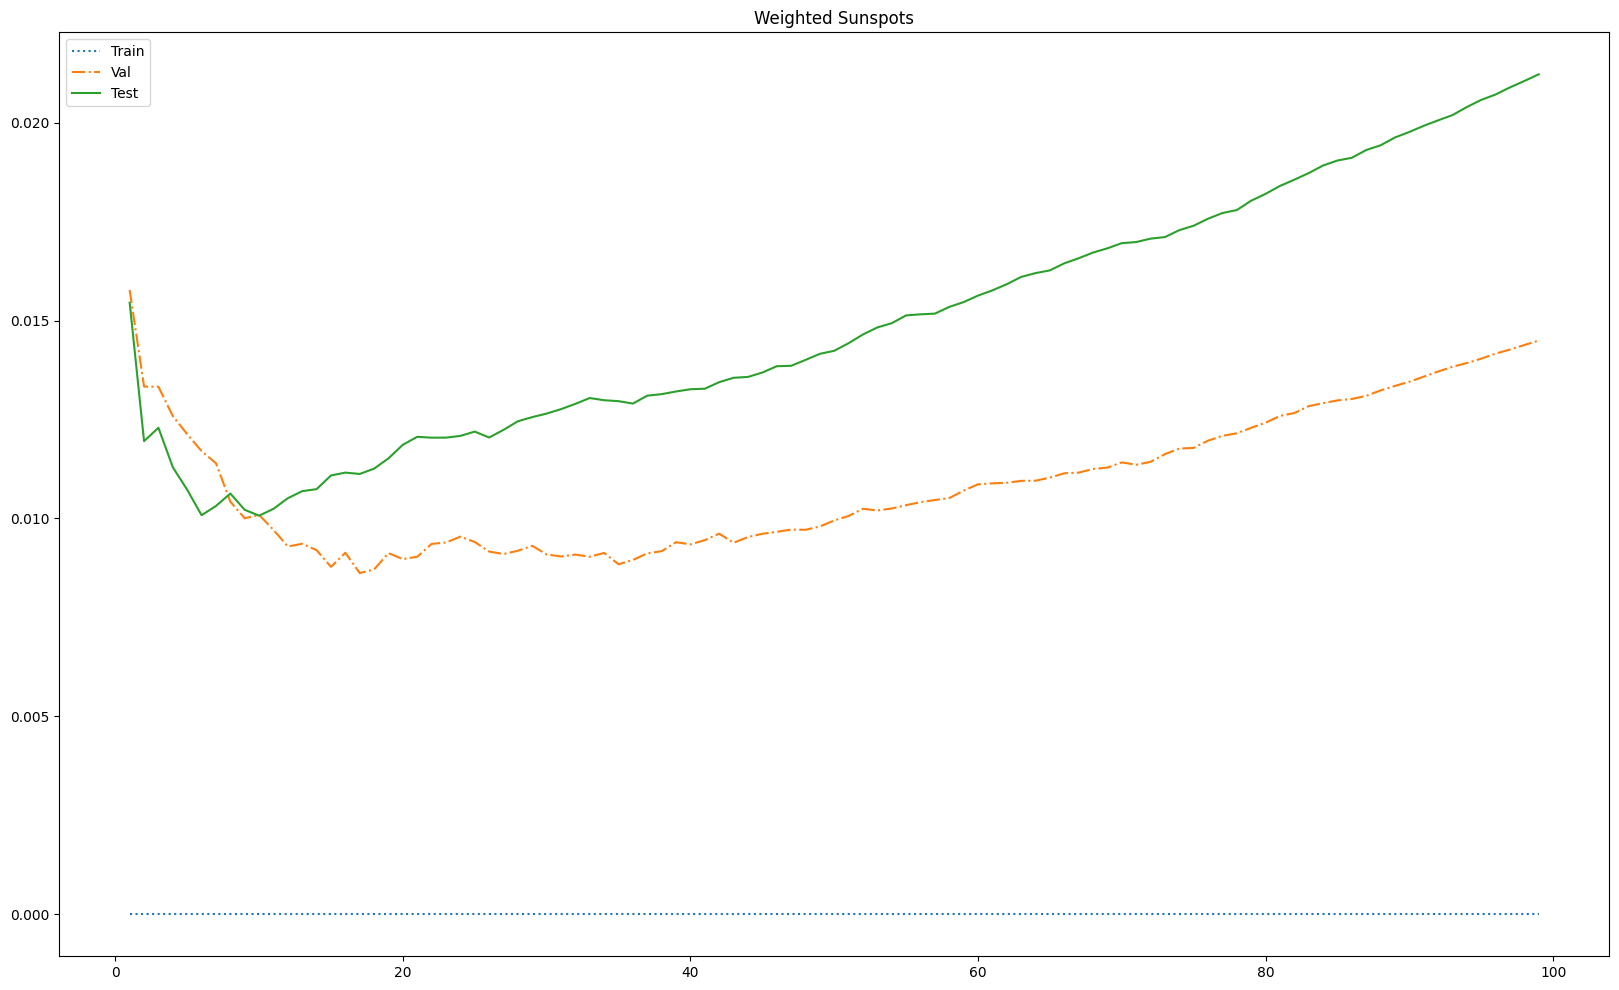

In [30]:
_, errorsTrain, errorsVal, errorsTest = entrenar_knn(KNeighborsRegressor(weights='distance'), neighbors, xTrain, yTrain, xVal, yVal, xTest, yTest)
plotEntrenamiento2("Weighted Sunspots", errorsTrain, errorsVal, errorsTest, range(1, neighbors))

### ANN

In [31]:
learning_rate = 0.05
momentum = 0.3
sub_epocas = 200
cant_epocas = 2000
neuronas = 6
batch_size = 12

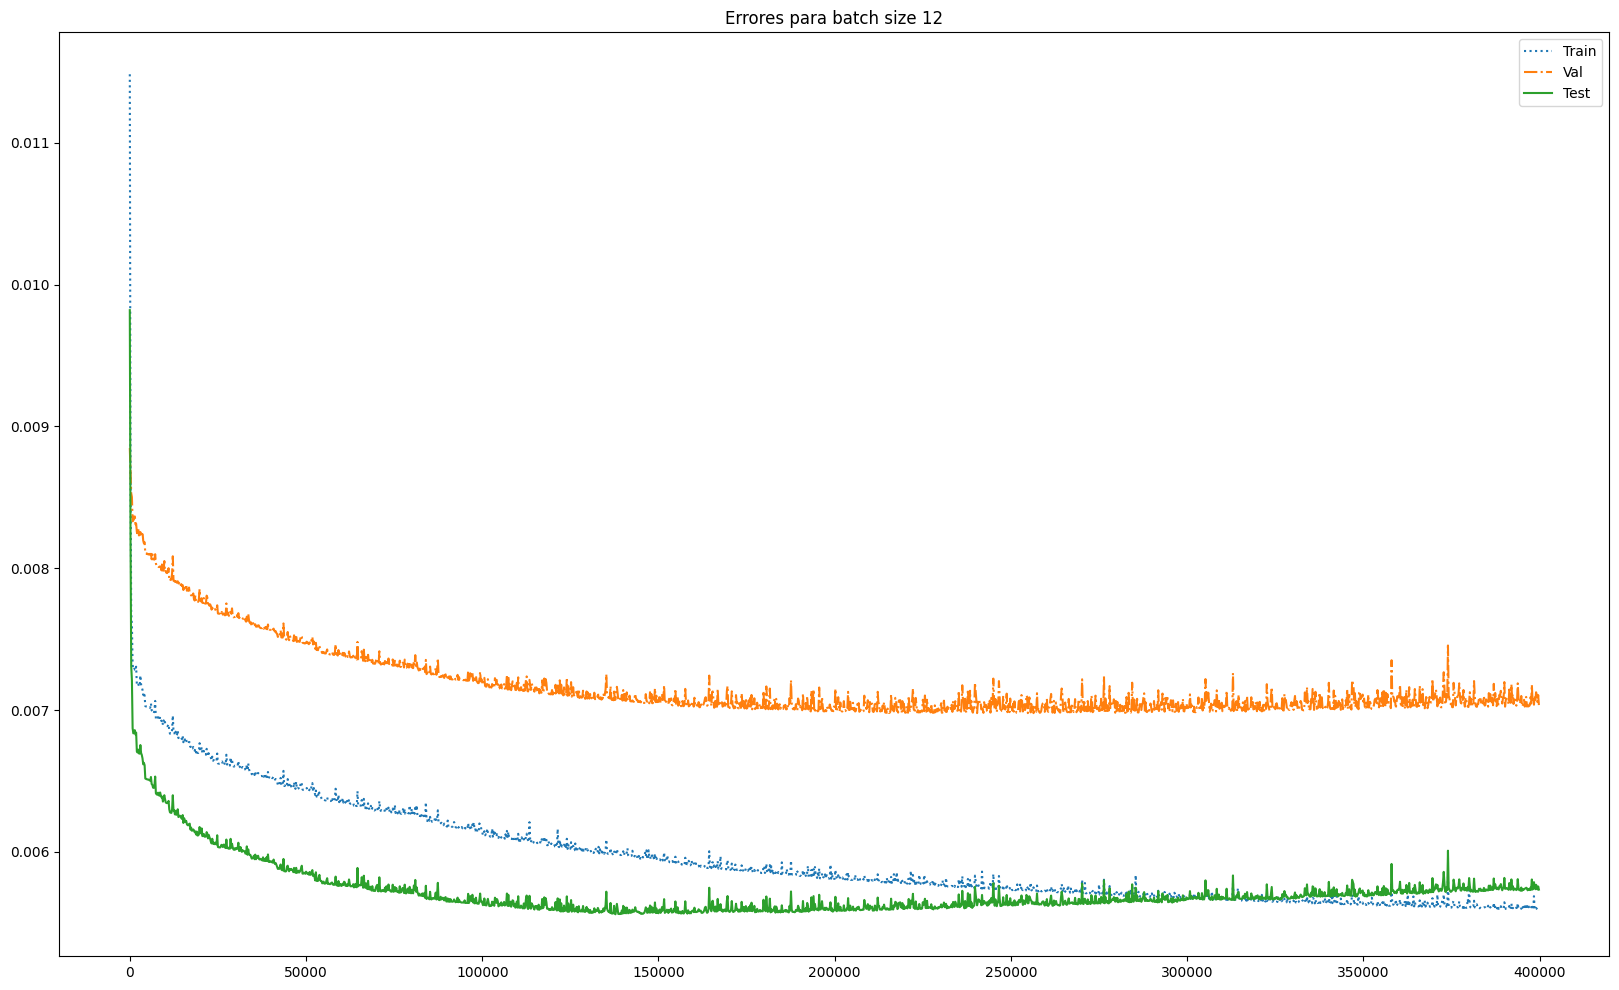

In [32]:
regre = MLPRegressor(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=0, batch_size=batch_size, learning_rate='constant', learning_rate_init=learning_rate, 
                      momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epocas)

red, error_train, error_val, error_test = entrenar_red(regre, cant_epocas, xTrain, yTrain, xVal, yVal, xTest, yTest)

plotEntrenamiento2(f'Errores para batch size 12', error_train, error_val, error_test, np.array(range(cant_epocas)) * sub_epocas)

### Comentarios

Por lo que se puede ver de los gráficos resultantes, utilizar votación pesada por distancia inversa no contribuyó a una mejoría de los errores. De hecho, los errores (fuera del de entrenamiento) resultaron ser casi iguales. Además, estos no lograron tener menor error que si se utilizara ANN para su resolución.

Un último dato a remarcar es que, como se vio en el ejercicio anterior, los errores de entrenamiento son 0 ya que se usaron pesos por distancia.

## Ikeda

In [46]:
data = pd.read_csv('./ikeda.data', header=None, delim_whitespace=True, names=['1', '2', '3', '4', '5', 'Target'])
test = pd.read_csv('./ikeda.test', header=None, delim_whitespace=True, names=['1', '2', '3', '4', '5', 'Target'])

xData = data[['1', '2', '3', '4', '5']].values
yData = data['Target'].values

xTrain, xVal, yTrain, yVal = train_test_split(xData, yData, test_size=0.25)

testDF = test.sample(n=2000)

xTest = testDF[['1', '2', '3', '4', '5']].values
yTest = testDF['Target'].values

C:\Users\nanoc\AppData\Local\Temp\ipykernel_17472\3292490748.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('./ikeda.data', header=None, delim_whitespace=True, names=['1', '2', '3', '4', '5', 'Target'])
C:\Users\nanoc\AppData\Local\Temp\ipykernel_17472\3292490748.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test = pd.read_csv('./ikeda.test', header=None, delim_whitespace=True, names=['1', '2', '3', '4', '5', 'Target'])


### KNN

In [47]:
neighbors = 76

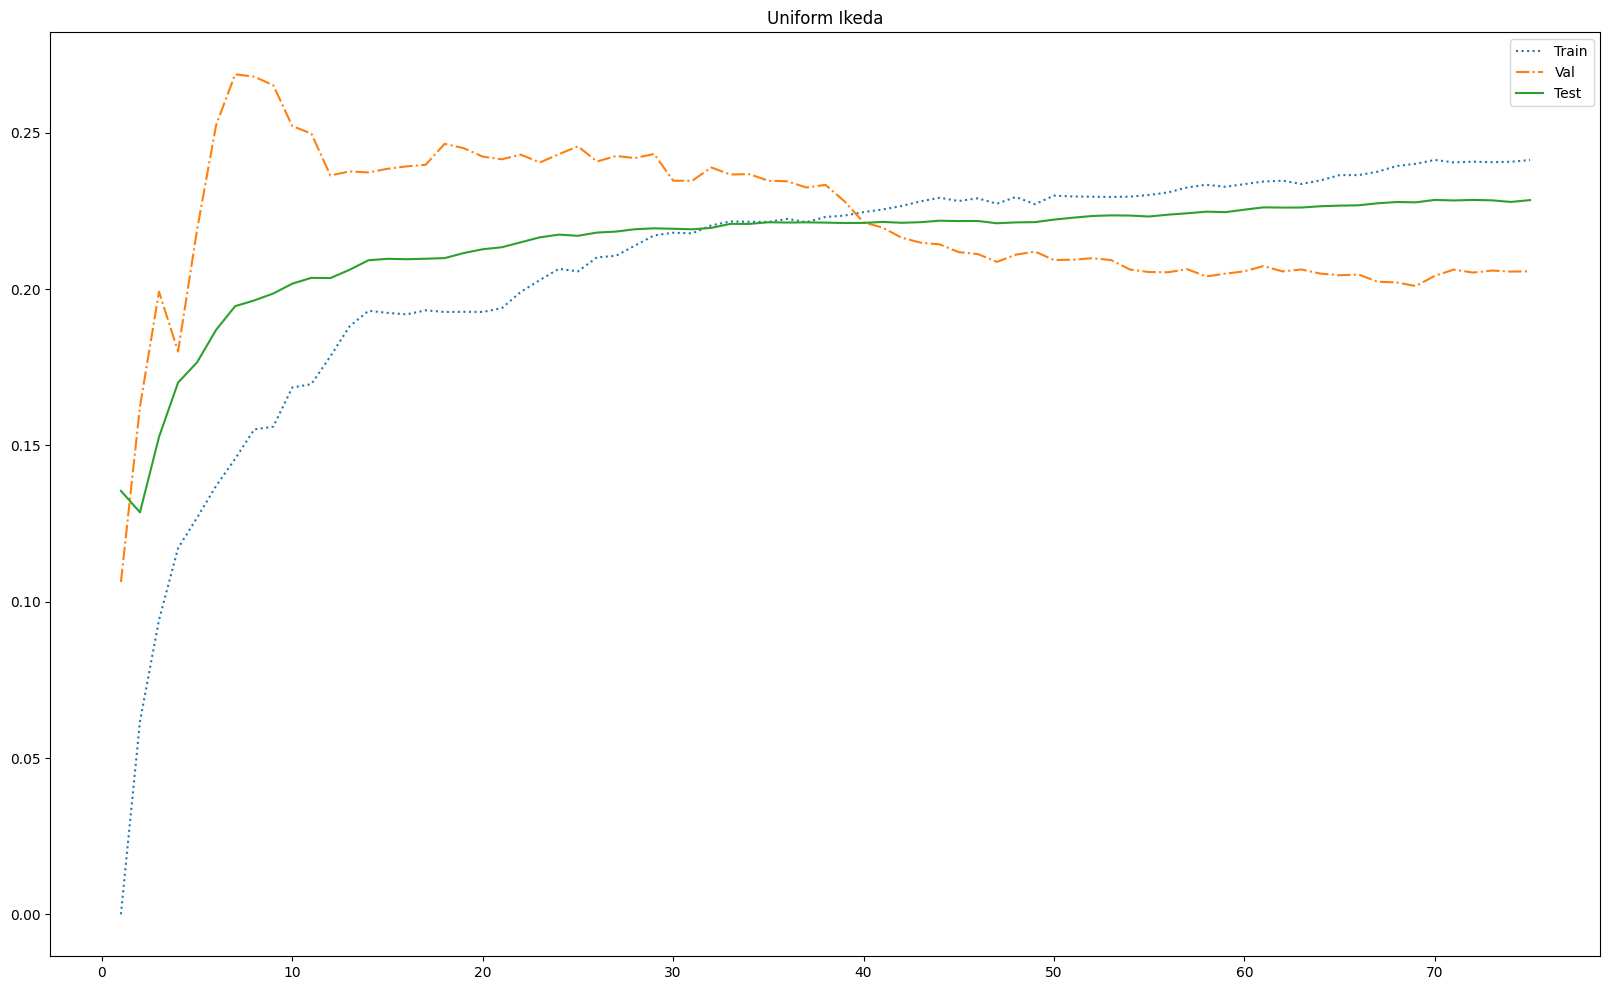

In [48]:
_, errorsTrain, errorsVal, errorsTest = entrenar_knn(KNeighborsRegressor(), neighbors, xTrain, yTrain, xVal, yVal, xTest, yTest)
plotEntrenamiento2("Uniform Ikeda", errorsTrain, errorsVal, errorsTest, range(1, neighbors))

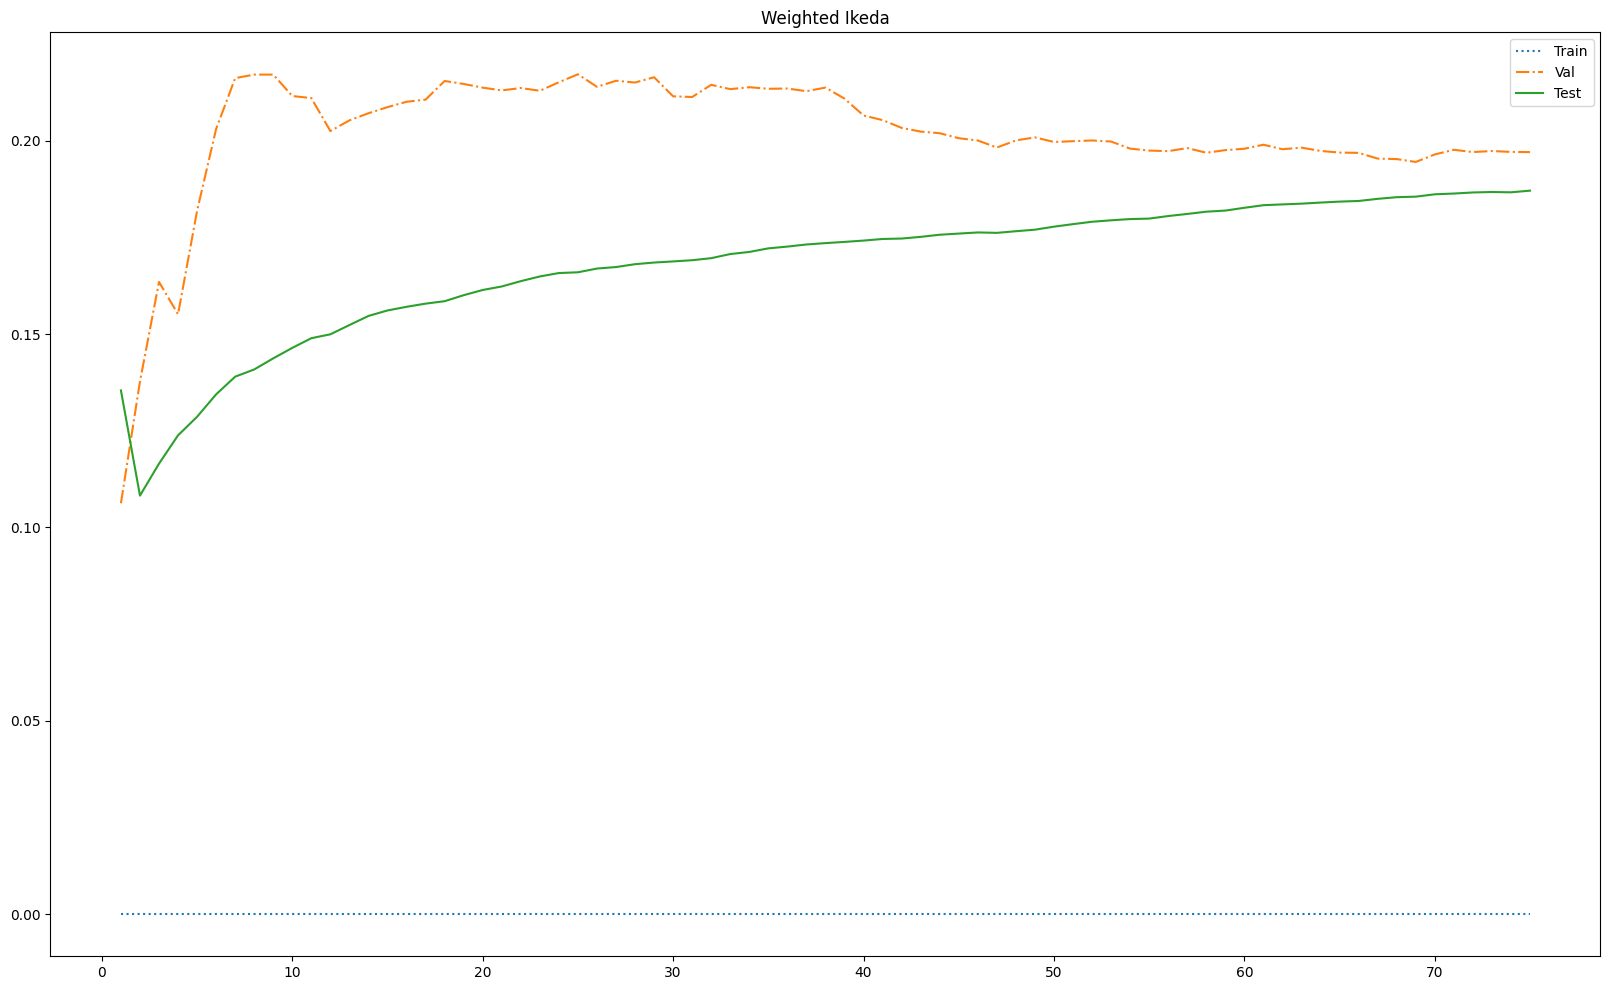

In [49]:
_, errorsTrain, errorsVal, errorsTest = entrenar_knn(KNeighborsRegressor(weights='distance'), neighbors, xTrain, yTrain, xVal, yVal, xTest, yTest)
plotEntrenamiento2("Weighted Ikeda", errorsTrain, errorsVal, errorsTest, range(1, neighbors))

### ANN

In [50]:
momentum = 0.9
learning_rate = 0.01
iters = 10
neuronas = 30
sub_epocas = 50
cant_epocas = 400

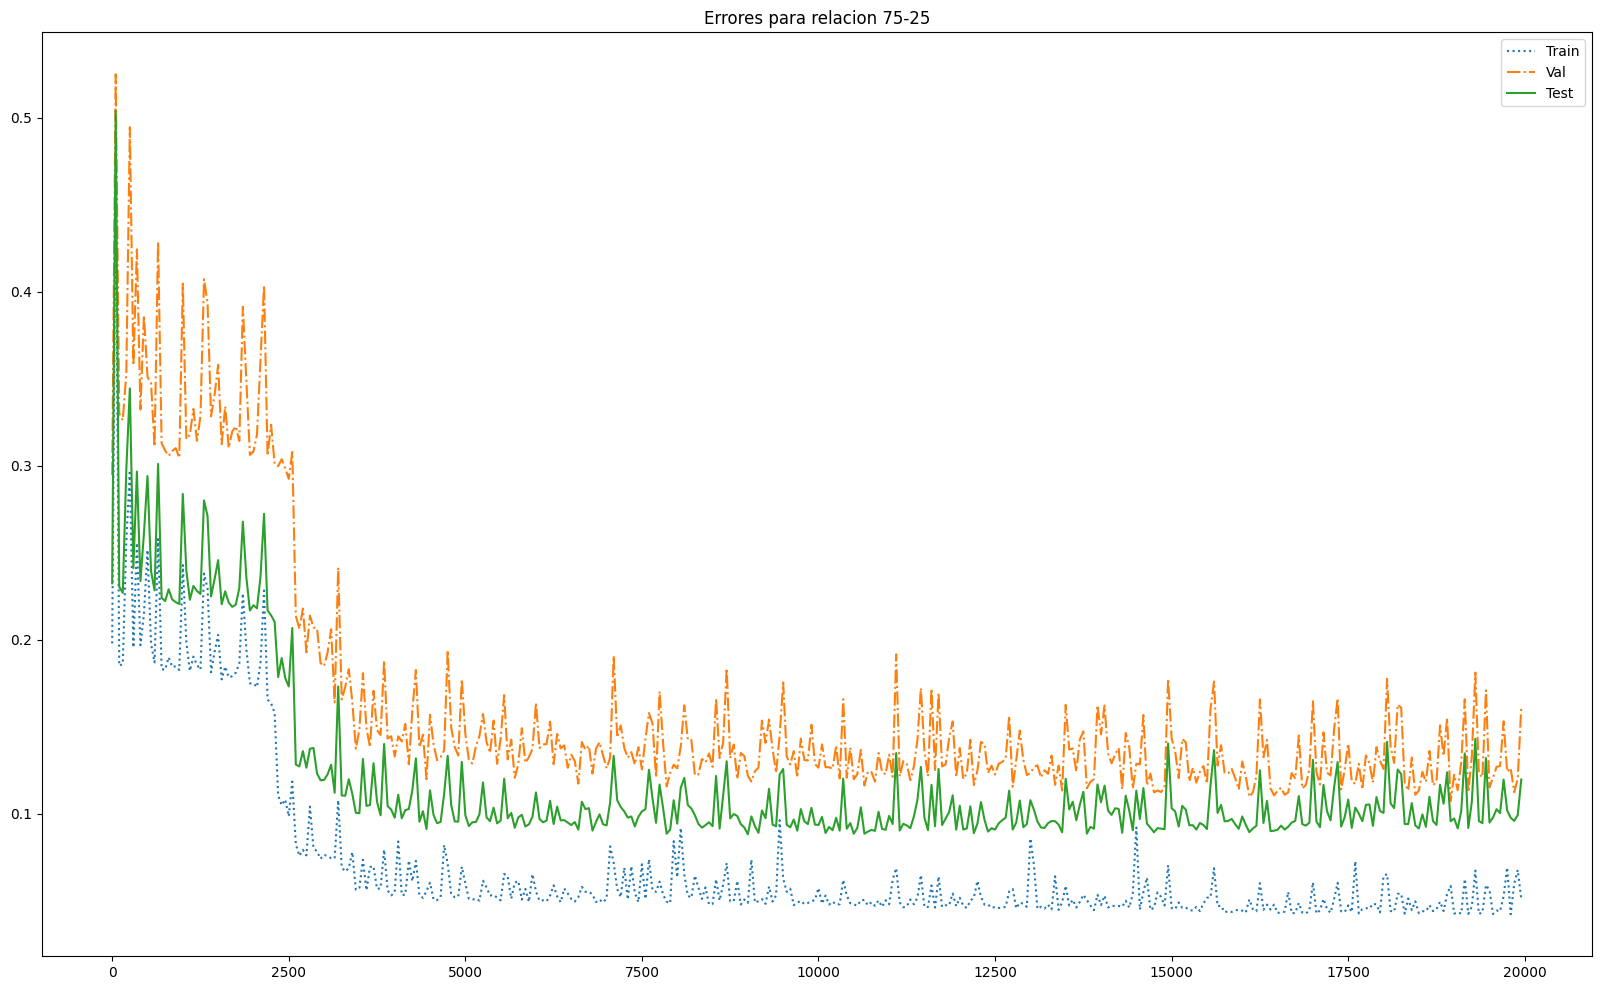

In [51]:
regre = MLPRegressor(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=learning_rate, 
                       momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epocas)

best_red, error_train, error_val, error_test = entrenar_red(regre, cant_epocas, xTrain, yTrain, xVal, yVal, xTest, yTest)

plotEntrenamiento2(f'Errores para relacion 75-25', error_train, error_val, error_test, np.array(range(cant_epocas)) * sub_epocas)

### Comentarios

A diferencia del caso de Sunspots, en Ikeda, utilizar pesos por distancia inversa sí logra una mejoría sobre uniforme, en un poco menos de 0.05 de error. También, ahora se logró alcanzar un error tan bajo como usando ANN.

# Ejercicio E

## Calculos

In [51]:
def minMaxDist(elems):
    list = [math.dist(a, b) for a in elems for b in elems]

    return min(list), max(list)

In [52]:
def entrenar_knn_radius(clf, divitions, xTrain, yTrain, xVal, yVal, xTest, yTest):
    if type(clf) == KNeighborsClassifier:
        errorFunc = sk.metrics.zero_one_loss
    else:
        errorFunc = sk.metrics.mean_squared_error

    minD, maxD = minMaxDist(xTrain)
    
    distances = [minD + (n * (maxD - minD) / divitions) for n in range(divitions + 1)]

    bestError = 1
    for d in distances:
        clf.radius = d
        clf.fit(xTrain, yTrain)

        errorVal = errorFunc(yVal, clf.predict(xVal))

        if (errorVal < bestError):
            bestClf = copy.deepcopy(clf)
            bestError = errorVal
            errorTrain = errorFunc(yTrain, clf.predict(xTrain))
            errorTest = errorFunc(yTest, clf.predict(xTest))

    return bestClf, errorTrain, bestError, errorTest

In [53]:
dimentions = [2, 4, 8, 16, 32]
divitions = 100
iterations = 20
neighbors = 100

errorParaD = {}
errorDiagD = {}
errorParaKOW = {}
errorDiagKOW = {}
errorParaK50W = {}
errorDiagK50W = {}

In [54]:
for i in dimentions:
    test = diagonales(10000, i, 0.78)
    xTest = test[['d' + str(n + 1) for n in range(i)]].values
    yTest = test['Target'].values
    
    errors = []
    errorsIW = [(0, 0, 0) for _ in range(neighbors - 1)]

    for _ in range(iterations):

        train = diagonales(200, i, 0.78)
        xTrain = train[['d' + str(n + 1) for n in range(i)]].values
        yTrain = train['Target'].values

        val = diagonales(50, i, 0.78)
        xVal = val[['d' + str(n + 1) for n in range(i)]].values
        yVal = val['Target'].values

        _, errorsTrain, _, errorsTest = entrenar_knn_radius(KNeighborsClassifier(weights='distance'), divitions, xTrain, yTrain, xVal, yVal, xTest, yTest)

        errors.append((errorsTrain, errorsTest))

        _, errorsTrain, errorsVal, errorsTest = entrenar_knn(KNeighborsClassifier(weights='distance'), neighbors, xTrain, yTrain, xVal, yVal, xTest, yTest)

        errorsIW = [(errorsIW[n][0] + (errorsTrain[n] / iterations), errorsIW[n][1] + (errorsVal[n] / iterations), errorsIW[n][2] + (errorsTest[n] / iterations)) for n in range(neighbors - 1)]

    errorDiagD[i] = (np.average([x for x, y in errors]), np.average([y for x, y in errors]))
    
    errorDiagKOW[i] = minError(errorsIW)
    errorDiagK50W[i] = (errorsIW[49][0], errorsIW[49][2])

In [55]:
for i in dimentions:
    test = paralelas(10000, i, 0.78)
    xTest = test[['d' + str(n + 1) for n in range(i)]].values
    yTest = test['Target'].values
    
    errors = []
    errorsIW = [(0, 0, 0) for _ in range(neighbors - 1)]

    for _ in range(iterations):

        train = paralelas(200, i, 0.78)
        xTrain = train[['d' + str(n + 1) for n in range(i)]].values
        yTrain = train['Target'].values

        val = paralelas(50, i, 0.78)
        xVal = val[['d' + str(n + 1) for n in range(i)]].values
        yVal = val['Target'].values

        _, errorsTrain, _, errorsTest = entrenar_knn_radius(KNeighborsClassifier(weights='distance'), divitions, xTrain, yTrain, xVal, yVal, xTest, yTest)

        errors.append((errorsTrain, errorsTest))

        _, errorsTrain, errorsVal, errorsTest = entrenar_knn(KNeighborsClassifier(weights='distance'), neighbors, xTrain, yTrain, xVal, yVal, xTest, yTest)

        errorsIW = [(errorsIW[n][0] + (errorsTrain[n] / iterations), errorsIW[n][1] + (errorsVal[n] / iterations), errorsIW[n][2] + (errorsTest[n] / iterations)) for n in range(neighbors - 1)]

    errorParaD[i] = (np.average([x for x, y in errors]), np.average([y for x, y in errors]))
    
    errorParaKOW[i] = minError(errorsIW)
    errorParaK50W[i] = (errorsIW[49][0], errorsIW[49][2])

## Graficos

In [56]:
errDiagD = ([v[0] for k, v in errorDiagD.items()], [v[1] for k, v in errorDiagD.items()])
errParaD = ([v[0] for k, v in errorParaD.items()], [v[1] for k, v in errorParaD.items()])
errDiagKOW = ([v[0] for k, v in errorDiagKOW.items()], [v[1] for k, v in errorDiagKOW.items()])
errParaKOW = ([v[0] for k, v in errorParaKOW.items()], [v[1] for k, v in errorParaKOW.items()])
errDiagK50W = ([v[0] for k, v in errorDiagK50W.items()], [v[1] for k, v in errorDiagK50W.items()])
errParaK50W = ([v[0] for k, v in errorParaK50W.items()], [v[1] for k, v in errorParaK50W.items()])

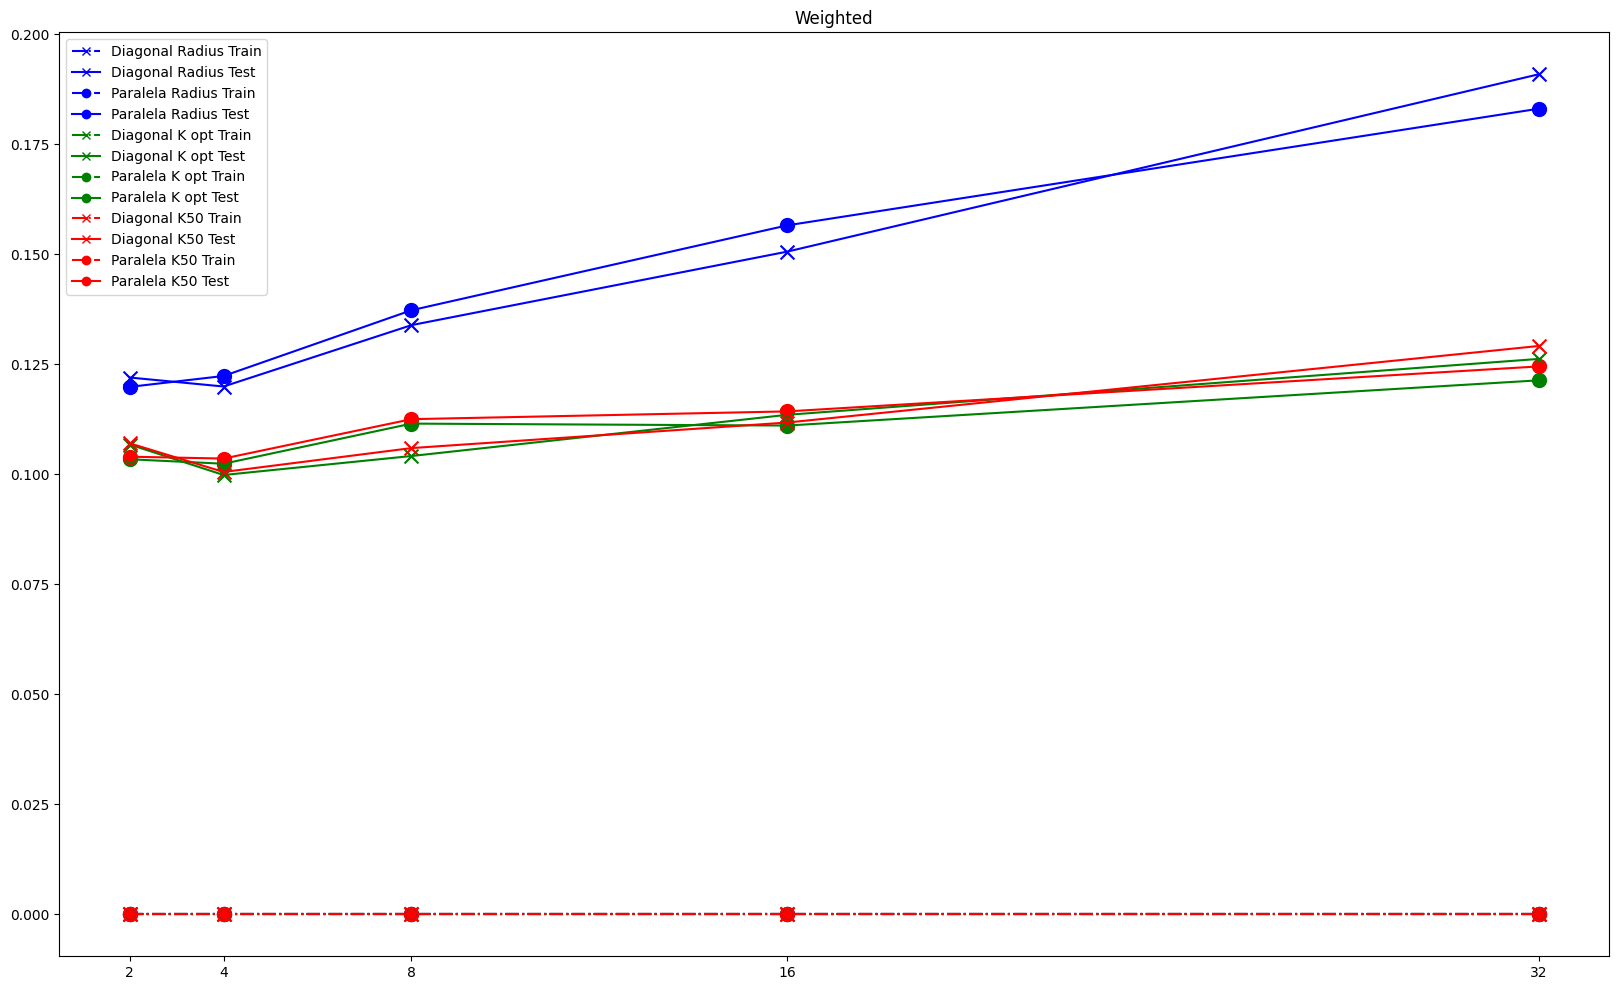

In [57]:
plotEntrenamiento8("Weighted", errDiagD, errParaD, errDiagKOW, errParaKOW, errDiagK50W, errParaK50W, dimentions)

## Comentarios

Como se puede ver, el error conseguido evaluando la clase de la muestra a partir de los puntos en cierto radio de esta fue peor que el de K=50 y K óptimo. Esto se debe a que en este caso, se tomaron 100 divisiones de la distancia máxima encontrada entre dos puntos del conjunto de entrenamiento. Para ir teniendo en cuenta un vecino más a la vez, se tendrían que haber hecho muchas más divisiones. Por ejemplo, desde "distanciaMáxima x 40/100" a "distanciaMáxima x 41/100", es posible que se hayan tenido en cuenta 5 puntos más y algunos de estos hagan que se consiga una peor predicción de la clase de la muestra.

Así que, probablemente, aumentar mucho más la cantidad de divisiones que se hacen a la distancia máxima para los testeos haga que el error vaya bajando hasta llegar al de K óptimo. También, cabe aclarar que el testeo por radio es mucho más rápido que el de número de vecinos ya que se tienen que hacer muchas menos operaciones para encontrar a los vecinos a tener en cuenta, y aumentar la cantidad de divisiones hará que sea más lento el testeo de estas.

# Ejercicio F

In [18]:
columns = ['Target'] + [str(n) for n in range(1, 7)]
data = pd.read_csv('./pelis.csv', header=0, delimiter=",", names=columns)

xMovie = data.drop('Target', axis=1).values
yMovie = data['Target'].values

In [19]:
data = pd.read_csv('./usuarios.csv', header=None, delimiter=",").T

data = data.drop(data.index[0])

xUser = data.drop(data.columns[0], axis=1).values
yUser = data[data.columns[0]].values

In [106]:
def maxDistances(lists):
    return [max(sublist) for sublist in lists]

def maxDistance(lists):
    return max([sublist[-1] for sublist in lists])

def getMultiplier(rating):
    if rating == 1 or rating == 5:
        return 0
    elif rating == 3:
        return 2/3
    else:
        return 1/3

def getDist(dist, maxDist, rating):
    distToCenter = (maxDist / 2) - dist
    if rating >= 3:
        return dist + (getMultiplier(rating) * distToCenter)
    else:
        return maxDist - dist - (getMultiplier(rating) * distToCenter)

def getMovies(xUsers, yUsers, xMovies, yMovies, userIndex):
    movies = [(idx, pd.to_numeric(r)) for idx, r in enumerate(xUsers[userIndex]) if not(pd.isna(r))]

    moviesIndexes, moviesRatings = [idx for idx, _ in movies], [r for _, r in movies]

    xUsers = list(map(lambda x: list(map(lambda r: 3 if pd.isna(r) else int(r), x)), xUsers))

    xTrain = [moviesRatings]
    yTrain = [yUsers[userIndex]]
    
    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(xTrain, yTrain)

    xTest = [[ratings[i] for i in moviesIndexes] for ratings in np.delete(xUsers, userIndex, 0)]
    yTest = np.delete(yUsers, userIndex, 0)

    distances, _ = clf.kneighbors(xTest, 1)

    maxDist = maxDistance(distances)

    distances = [d / maxDist for d in distances]

    ratingsPerMovie = np.delete(np.array(np.delete(xUsers, userIndex, 0)).T, moviesIndexes, 0)

    distToMovies = [sum([(1/r) * distances[idx][0] for idx, r in enumerate(ratings)]) / len(ratings) for ratings in ratingsPerMovie]

    xTrain = [xMovies[i] for i in moviesIndexes]
    yTrain = [yMovies[i] for i in moviesIndexes]

    xTest = np.delete(xMovies, moviesIndexes, 0)
    yTest = np.delete(yMovies, moviesIndexes, 0)

    amountMovies = len(moviesIndexes)

    clf = KNeighborsClassifier(n_neighbors=amountMovies).fit(xTrain, yTrain)

    distances, points = clf.kneighbors(xTest, amountMovies)

    maxDists = maxDistances(distances.T)

    rank = {}

    for idx, x in enumerate(yTest):
        rank[x] = (distToMovies[idx] + sum([getDist(distances[idx][n], maxDists[n], moviesRatings[points[idx][n]]) / sum(maxDists) for n in range(amountMovies)])) / 2

    return rank

for u in [8, 9]:
    dict = getMovies(xUser, yUser, xMovie, yMovie, u)

    minValues = heapq.nsmallest(2, dict.items(), key=lambda x: x[1])

    print(f"Para U{u+1}, las peliculas recomendadas son {minValues[0][0]} y {minValues[1][0]}")

print("Ambas en orden de la mas recomendada")

Para U9, las peliculas recomendadas son 17 y 19
Para U10, las peliculas recomendadas son 10 y 23
Ambas en orden de la mas recomendada


Para resolver el problema de las recomendaciones, comencé por la recomendación de películas a partir de una combinación entre los atributos de las películas que vio un usuario y las puntuaciones otorgadas por el mismo. De esta manera, generé un KNeighborsClassifier que me da las distancias de las películas restantes a las que vio el usuario.

El primer problema que se presentó fue cómo recomendarle una película a alguien en base a sus ratings negativos, y además, cómo hacer para que mejores ratings impacten más positivamente que los peores. Así, al conseguir las distancias entre las películas, hice que la distancia desde una película hasta todas las que vio el usuario se sumen luego de hacer una operación sobre estas. La operación consiste en que, si el rating de la película destino es 1 o 2, la distancia se pasará hasta el otro lado del espectro; si la distancia era muy pequeña ahora será muy grande, y si era muy grande ahora será muy pequeña. Esto se debe a que, si al usuario no le gustaba la película y la película a predecir es muy distinta de esta, esta misma le podría llegar a gustar. Luego de esto, consideré que las puntuaciones más importantes son las más altas y bajas, por lo que, mientras un puntaje se acerque más al 3, la distancia se acercará más al centro del espectro, para que no tenga tanta relevancia al momento de la suma con las otras películas.

Un segundo problema surgió al intentar conseguir usuarios con gustos parecidos, ya que hay muchos valores nulos debido a que no todos los usuarios vieron todas las películas del catálogo. De esta manera, siguiendo el mismo pensamiento de antes, que una puntuación de 3 se podría ver como "indiferencia" hacia la película, entrené un KNeighborsClassifier con las películas que vio el usuario seleccionado y, en la parte del testeo, inserté un rating de 3 en las películas que el resto de los usuarios no puntuaron. Esto se me ocurrió porque, si una persona no vio una película, esto implica cierta indiferencia por ella.
Aquí, entonces, conseguí los usuarios que tienen gustos parecidos al seleccionado a partir de los ratings puestos. Habiéndolos conseguido, evalué las películas que les gustaron y conseguí una lista con valores para cada película que muestran las que se supone que le gustarían al usuario. Cabe aclarar que, para cada película, se tendrán en cuenta las evaluaciones de cada usuario en mayor o menor medida dependiendo de la cercanía al usuario seleccionado.
Un posible cambio que se podría hacer aquí sería crear una IA que dé un rating de las películas no vistas a partir de los atributos y ratings de las que el usuario sí vio. De esta manera, se tendría una mejor aproximación en la recomendación de usuarios con gustos similares.

Tanto de la primera parte como de la segunda, conseguí dos listas que indican qué tan probable es que al usuario seleccionado le guste una película a partir de los atributos de las películas que vio y de los gustos que tiene el resto de la gente. Los valores de estas dos listas están en una escala del 0 al 1. Finalmente, para combinarlas, probé con el promedio de los valores y el factor entre estos, y decidí continuar con el promedio porque, de la otra manera, si uno de los valores es muy bueno, este tendrá un gran peso en el valor final y considero que esto no debería pasar, sino que se tendrían que tomar con igual peso ambos valores.